In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pwd

'/content'

In [3]:
cd drive/MyDrive/병렬분산시스템

/content/drive/MyDrive/병렬분산시스템


In [ ]:
!nvidia-smi

Sat Dec  4 19:02:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%writefile kdk.c

#include<stdio.h>

int main(){
    printf("kdk");
}

Writing kdk.c


In [ ]:
!gcc -o kdk kdk.c

In [ ]:
!ls

실습.ipynb  kdk  kdk.c


In [ ]:
!./kdk

kdk

# 3장

In [ ]:
%%writefile hello_world.cu

#include <stdio.h>

int main(void){
    printf("Hello, World!\n");
    return 0;
}

Writing hello_world.cu


In [ ]:
!nvcc -o hello_world hello_world.cu

In [ ]:
!./hello_world

Hello, World!


In [ ]:
%%writefile simple_kernel.cu

#include <stdio.h>

__global__ void kernel(void){
    
}

int main(void){
    kernel<<<1,1>>>();
    printf("Hello, World!\n");
    return 0;
}

Writing simple_kernel.cu


In [ ]:
!nvcc -o simple_kernel simple_kernel.cu

In [ ]:
!./simple_kernel

Hello, World!


In [ ]:
%%writefile simple_kernel_params.cu

#include <stdio.h>

__global__ void add(int a, int b, int *c){
    *c = a + b;
}

int main(void){
    int c;
    int *dev_c;
    cudaMalloc((void**)&dev_c, sizeof(int));

    add<<<1,1>>>(2,7,dev_c);

    cudaMemcpy(&c, dev_c, sizeof(int), cudaMemcpyDeviceToHost);
    printf("2 + 7 = %d\n",c);
    cudaFree(dev_c);

    return 0;
}

Writing simple_kernel_params.cu


In [ ]:
!nvcc -o simple_kernel_params simple_kernel_params.cu

In [ ]:
!ls

add_loop_gpu	 hello_world.cu  kdk.c		   simple_kernel_params
add_loop_gpu.cu  실습.ipynb	 simple_kernel	   simple_kernel_params.cu
hello_world	 kdk		 simple_kernel.cu


In [ ]:
!./simple_kernel_params

2 + 7 = 9


In [ ]:
%%writefile enum_gpu.cu

#include <stdio.h>

int main(void){
    cudaDeviceProp prop;

    int count;
    cudaGetDeviceCount(&count);
    for(int i=0;i<count;i++){
        cudaGetDeviceProperties(&prop,i);
        printf("  --- General Information for device %d ---\n",i);
        printf("Name :  %s\n",prop.name);
        printf("Compute capability: %d.%d\n", prop.major, prop.minor);
        printf("Clock rate: %d\n", prop.clockRate);
        printf("Device copy overlap:  ");
        if (prop.deviceOverlap)
          printf("Enabled\n");
        else 
          printf("Disabled\n");
        printf("Kernel execution timeout :  ");
        if (prop.kernelExecTimeoutEnabled)
          printf("Enabled\n");
        else
          printf("Disabled\n");
        
        printf("  --- Memory Information for device %d ---\n",i);
        printf("Total global mem: %ld\n", prop.totalGlobalMem);
        printf("Total constant mem: %ld\n", prop.totalConstMem);
        printf("Max mem pitch:  %ld\n", prop.memPitch);
        printf("Texture Alignment:  %ld\n", prop.textureAlignment);

        printf("  --- Mp Information for deviece %d ---\n",i);
        printf("Multiprocessor count: %d\n", prop.multiProcessorCount);
        printf("Shared mem per mp:  %ld\n", prop.sharedMemPerBlock);
        printf("Registers per mp: %d\n", prop.regsPerBlock);
        printf("Threads in warp:  %d\n", prop.warpSize);
        printf("Max threads per block:  %d\n", prop.maxThreadsPerBlock);
        printf("Max thread dimesions: (%d,%d,%d)\n", prop.maxThreadsDim[0], prop.maxThreadsDim[1], prop.maxThreadsDim[2]);
        printf("Max grid dimensions:  (%d,%d,%d)\n", prop.maxGridSize[0], prop.maxGridSize[1], prop.maxGridSize[2]);
        printf("\n");

    }
}

Writing enum_gpu.cu


In [ ]:
!nvcc -o enum_gpu enum_gpu.cu

In [ ]:
!./enum_gpu

  --- General Information for device 0 ---
Name :  Tesla P100-PCIE-16GB
Compute capability: 6.0
Clock rate: 1328500
Device copy overlap:  Enabled
Kernel execution timeout :  Disabled
  --- Memory Information for device 0 ---
Total global mem: 17071734784
Total constant mem: 65536
Max mem pitch:  2147483647
Texture Alignment:  512
  --- Mp Information for deviece 0 ---
Multiprocessor count: 56
Shared mem per mp:  49152
Registers per mp: 65536
Threads in warp:  32
Max threads per block:  1024
Max thread dimesions: (1024,1024,64)
Max grid dimensions:  (2147483647,65535,65535)



In [ ]:
%%writefile set_gpu.cu

#include <stdio.h>

int main(void){
    cudaDeviceProp prop;
    int dev;

    cudaGetDevice(&dev);
    printf("ID of current CUDA device:  %d\n",dev);

    memset(&prop, 0, sizeof(cudaDeviceProp));
    prop.major = 8;
    prop.minor = 6;
    cudaChooseDevice(&dev, &prop);
    printf("ID of cuda device closest to revision 8.6:  %d\n",dev);

    cudaSetDevice(dev);
}

Writing set_gpu.cu


In [ ]:
!nvcc -o set_gpu set_gpu.cu

In [ ]:
!./set_gpu

ID of current CUDA device:  0
ID of cuda device closest to revision 8.6:  0


# 4장

In [ ]:
%%writefile vector_add_cpu.cu

#include <stdio.h>

#define N 10

int main(void){
    int a[N],b[N],c[N];

    for (int i = 0;i<N;i++){
        a[i] = i;
        b[i] = i * i;
    }

    for (int i = 0;i<N;i++){
        c[i] = a[i] + b[i];
    }

    for (int i = 0;i<N;i++){
        printf("%d + %d = %d\n", a[i], b[i], c[i]);
    }

    return 0;
}

Writing vector_add_cpu.cu


In [ ]:
!nvcc -o vector_add_cpu vector_add_cpu.cu

In [ ]:
!./vector_add_cpu

0 + 0 = 0
1 + 1 = 2
2 + 4 = 6
3 + 9 = 12
4 + 16 = 20
5 + 25 = 30
6 + 36 = 42
7 + 49 = 56
8 + 64 = 72
9 + 81 = 90


In [ ]:
%%writefile vector_add_mcpu.cu

#include <stdio.h>

#define N 20
#define K 4

void add(int myid, int *a, int *b, int *c){
    int tid = myid;
    while(tid < N){
        c[tid] = a[tid] + b[tid];
        tid += K;
    }
}

int main(void){
    int a[N], b[N], c[N];

    for(int i = 0;i<N;i++){
        a[i] = i;
        b[i] = i*i;
    }

    add(0,a,b,c); add(1,a,b,c); add(2,a,b,c); add(3,a,b,c);

    for (int i = 0;i<N;i++){
        printf("%d + %d = %d\n", a[i], b[i], c[i]);
    }

    return 0;

}

Writing vector_add_mcpu.cu


In [ ]:
!nvcc -o vector_add_mcpu vector_add_mcpu.cu

In [ ]:
!./vector_add_mcpu

0 + 0 = 0
1 + 1 = 2
2 + 4 = 6
3 + 9 = 12
4 + 16 = 20
5 + 25 = 30
6 + 36 = 42
7 + 49 = 56
8 + 64 = 72
9 + 81 = 90
10 + 100 = 110
11 + 121 = 132
12 + 144 = 156
13 + 169 = 182
14 + 196 = 210
15 + 225 = 240
16 + 256 = 272
17 + 289 = 306
18 + 324 = 342
19 + 361 = 380


#5장

In [ ]:
%%writefile add_loop_gpu.cu

#include <stdio.h>

#define N 10

__global__ void add(int *a, int *b, int *c){
    int tid = blockIdx.x;
    if(tid < N)
        c[tid] = a[tid] + b[tid];
}

int main(void){
    int a[N], b[N], c[N];
    int *dev_a, *dev_b, *dev_c;

    cudaMalloc( (void**)&dev_a, N * sizeof(int));
    cudaMalloc( (void**)&dev_b, N * sizeof(int));
    cudaMalloc( (void**)&dev_c, N * sizeof(int));

    for(int i = 0; i<N; i++){
        a[i] = i;
        b[i] = i * i;
    }

    cudaMemcpy(dev_a, a, N * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(dev_b, b, N * sizeof(int), cudaMemcpyHostToDevice);
    add<<<N,1>>>(dev_a, dev_b,dev_c);
    
    cudaMemcpy(c, dev_c, N * sizeof(int), cudaMemcpyDeviceToHost);

    for(int i = 0;i<N;i++){
        printf("%d + %d = %d\n" , a[i], b[i], c[i]);
    }

    cudaFree(dev_a);
    cudaFree(dev_b);
    cudaFree(dev_c);

    return 0;
}

Writing add_loop_gpu.cu


In [ ]:
!nvcc -o add_loop_gpu add_loop_gpu.cu

In [ ]:
!ls

add_loop_gpu  add_loop_gpu.cu  실습.ipynb  kdk	kdk.c


In [ ]:
!./add_loop_gpu

0 + 0 = 0
1 + 1 = 2
2 + 4 = 6
3 + 9 = 12
4 + 16 = 20
5 + 25 = 30
6 + 36 = 42
7 + 49 = 56
8 + 64 = 72
9 + 81 = 90


#6장

In [ ]:
%%writefile hello_world.cu

#include <stdio.h>

__global__ void print_from_gpu(void){
    printf("Hello Wordl! from thread [%d,%d] \
    From device\n", threadIdx.x, blockIdx.x);
}

int main(void){
    printf("Hello World form host!\n");
    print_from_gpu<<<1,1>>>();
    cudaDeviceSynchronize();
    return 0;
}

Overwriting hello_world.cu


In [ ]:
!nvcc -o hello_world hello_world.cu

In [ ]:
!./hello_world

Hello World form host!
Hello Wordl! from thread [0,0]     From device


In [ ]:
%%writefile hello_world.cu

#include <stdio.h>

__global__ void print_from_gpu(void){
    printf("Hello Wordl! from thread [%d,%d] \
    From device\n", threadIdx.x, blockIdx.x);
}

int main(void){
    printf("Hello World form host!\n");
    print_from_gpu<<<2,1>>>();
    cudaDeviceSynchronize();
    return 0;
}

Overwriting hello_world.cu


In [ ]:
!nvcc -o hello_world hello_world.cu

In [ ]:
!./hello_world

Hello World form host!
Hello Wordl! from thread [0,1]     From device
Hello Wordl! from thread [0,0]     From device


In [ ]:
%%writefile hello_world.cu

#include <stdio.h>

__global__ void print_from_gpu(void){
    printf("Hello Wordl! from thread [%d,%d] \
    From device\n", threadIdx.x, blockIdx.x);
}

int main(void){
    printf("Hello World form host!\n");
    print_from_gpu<<<1,2>>>();
    cudaDeviceSynchronize();
    return 0;
}

Overwriting hello_world.cu


In [ ]:
!nvcc -o hello_world hello_world.cu

In [ ]:
!./hello_world

Hello World form host!
Hello Wordl! from thread [0,0]     From device
Hello Wordl! from thread [1,0]     From device


In [ ]:
%%writefile hello_world.cu

#include <stdio.h>

__global__ void print_from_gpu(void){
    printf("Hello Wordl! from thread [%d,%d,%d] From device\n", blockIdx.x, blockIdx.y, blockIdx.z);
}

int main(void){
    printf("Hello World form host!\n");
    dim3 Dg(3,2,3);
    print_from_gpu<<<Dg,1>>>();
    printf("host!\n");
    cudaDeviceSynchronize();
    return 0;
}

Overwriting hello_world.cu


In [ ]:
!nvcc -o hello_world hello_world.cu

In [ ]:
!./hello_world

Hello World form host!
host!
Hello Wordl! from thread [0,1,0] From device
Hello Wordl! from thread [0,1,2] From device
Hello Wordl! from thread [0,1,1] From device
Hello Wordl! from thread [1,0,2] From device
Hello Wordl! from thread [1,0,1] From device
Hello Wordl! from thread [1,0,0] From device
Hello Wordl! from thread [2,1,2] From device
Hello Wordl! from thread [2,0,1] From device
Hello Wordl! from thread [2,0,2] From device
Hello Wordl! from thread [1,1,1] From device
Hello Wordl! from thread [1,1,2] From device
Hello Wordl! from thread [2,0,0] From device
Hello Wordl! from thread [2,1,1] From device
Hello Wordl! from thread [1,1,0] From device
Hello Wordl! from thread [0,0,1] From device
Hello Wordl! from thread [0,0,2] From device
Hello Wordl! from thread [0,0,0] From device
Hello Wordl! from thread [2,1,0] From device


#7장

In [ ]:
%%writefile vector_addition.cu

#include <stdio.h>

#define N 512

void host_add(int *a, int *b, int *c){
    for(int idx = 0; idx<N; idx++){
        c[idx] = a[idx] + b[idx];
    }
}

void fill_array(int *data){
    for(int idx=0;idx<N;idx++){
        data[idx] = idx;
    }
}

void print_output(int *a, int *b, int *c){
    for(int idx = 0; idx<N; idx++){
        printf("\n %d + %d = %d", a[idx], b[idx], c[idx]);
    }
}

int main(void){
    int *a, *b, *c;
    int size = N * sizeof(int);

    a = (int *)malloc(size); fill_array(a);
    b = (int *)malloc(size); fill_array(b);
    c = (int *)malloc(size);

    host_add(a,b,c);

    print_output(a,b,c);
    
    free(a); free(b); free(c);

    return 0;
}

Overwriting vector_addition.cu


In [ ]:
!ls
!nvcc -o vector_addition vector_addition.cu

add_loop_gpu	 hello_world.cu  set_gpu.cu		  vector_add_cpu
add_loop_gpu.cu  실습.ipynb	 simple_kernel		  vector_add_cpu.cu
enum_gpu	 kdk		 simple_kernel.cu	  vector_addition.cu
enum_gpu.cu	 kdk.c		 simple_kernel_params	  vector_add_mcpu
hello_world	 set_gpu	 simple_kernel_params.cu  vector_add_mcpu.cu


In [ ]:
!./vector_addition


 0 + 0 = 0
 1 + 1 = 2
 2 + 2 = 4
 3 + 3 = 6
 4 + 4 = 8
 5 + 5 = 10
 6 + 6 = 12
 7 + 7 = 14
 8 + 8 = 16
 9 + 9 = 18
 10 + 10 = 20
 11 + 11 = 22
 12 + 12 = 24
 13 + 13 = 26
 14 + 14 = 28
 15 + 15 = 30
 16 + 16 = 32
 17 + 17 = 34
 18 + 18 = 36
 19 + 19 = 38
 20 + 20 = 40
 21 + 21 = 42
 22 + 22 = 44
 23 + 23 = 46
 24 + 24 = 48
 25 + 25 = 50
 26 + 26 = 52
 27 + 27 = 54
 28 + 28 = 56
 29 + 29 = 58
 30 + 30 = 60
 31 + 31 = 62
 32 + 32 = 64
 33 + 33 = 66
 34 + 34 = 68
 35 + 35 = 70
 36 + 36 = 72
 37 + 37 = 74
 38 + 38 = 76
 39 + 39 = 78
 40 + 40 = 80
 41 + 41 = 82
 42 + 42 = 84
 43 + 43 = 86
 44 + 44 = 88
 45 + 45 = 90
 46 + 46 = 92
 47 + 47 = 94
 48 + 48 = 96
 49 + 49 = 98
 50 + 50 = 100
 51 + 51 = 102
 52 + 52 = 104
 53 + 53 = 106
 54 + 54 = 108
 55 + 55 = 110
 56 + 56 = 112
 57 + 57 = 114
 58 + 58 = 116
 59 + 59 = 118
 60 + 60 = 120
 61 + 61 = 122
 62 + 62 = 124
 63 + 63 = 126
 64 + 64 = 128
 65 + 65 = 130
 66 + 66 = 132
 67 + 67 = 134
 68 + 68 = 136
 69 + 69 = 138
 70 + 70 = 140
 71 + 71 

In [ ]:
%%writefile vector_addition_gpu_block_only.cu

#include <stdio.h>

#define N 512

__global__ void device_add(int *a, int *b, int *c){
    c[blockIdx.x] = a[blockIdx.x] + b[blockIdx.x];
}

void fill_array(int *data){
    for(int idx=0;idx<N;idx++){
        data[idx] = idx;
    }
}

void print_output(int *a, int *b, int *c){
    for(int idx = 0; idx<N; idx++){
        printf("\n %d + %d = %d", a[idx], b[idx], c[idx]);
    }
}

int main(void){
    int *a, *b, *c;
    int *d_a, *d_b, *d_c;

    int size = N * sizeof(int);

    a = (int *)malloc(size); fill_array(a);
    b = (int *)malloc(size); fill_array(b);
    c = (int *)malloc(size);

    cudaMalloc((void **)&d_a, size);
    cudaMalloc((void **)&d_b, size);
    cudaMalloc((void **)&d_c, size);

    cudaMemcpy(d_a, a, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, b, size, cudaMemcpyHostToDevice);

    device_add<<<N,1>>>(d_a,d_b,d_c);

    cudaMemcpy(c, d_c, size, cudaMemcpyDeviceToHost);

    print_output(a,b,c);
    
    free(a); free(b); free(c);
    cudaFree(d_a); cudaFree(d_b); cudaFree(d_c); 

    return 0;
}

Overwriting vector_addition_gpu_block_only.cu


In [ ]:
!ls
!nvcc -o vector_addition_gpu_block_only vector_addition_gpu_block_only.cu

add_loop_gpu	 kdk.c			  vector_add_cpu.cu
add_loop_gpu.cu  set_gpu		  vector_addition
enum_gpu	 set_gpu.cu		  vector_addition.cu
enum_gpu.cu	 simple_kernel		  vector_addition_gpu_block_only
hello_world	 simple_kernel.cu	  vector_addition_gpu_block_only.cu
hello_world.cu	 simple_kernel_params	  vector_add_mcpu
실습.ipynb	 simple_kernel_params.cu  vector_add_mcpu.cu
kdk		 vector_add_cpu


In [ ]:
!./vector_addition_gpu_block_only


 0 + 0 = 0
 1 + 1 = 2
 2 + 2 = 4
 3 + 3 = 6
 4 + 4 = 8
 5 + 5 = 10
 6 + 6 = 12
 7 + 7 = 14
 8 + 8 = 16
 9 + 9 = 18
 10 + 10 = 20
 11 + 11 = 22
 12 + 12 = 24
 13 + 13 = 26
 14 + 14 = 28
 15 + 15 = 30
 16 + 16 = 32
 17 + 17 = 34
 18 + 18 = 36
 19 + 19 = 38
 20 + 20 = 40
 21 + 21 = 42
 22 + 22 = 44
 23 + 23 = 46
 24 + 24 = 48
 25 + 25 = 50
 26 + 26 = 52
 27 + 27 = 54
 28 + 28 = 56
 29 + 29 = 58
 30 + 30 = 60
 31 + 31 = 62
 32 + 32 = 64
 33 + 33 = 66
 34 + 34 = 68
 35 + 35 = 70
 36 + 36 = 72
 37 + 37 = 74
 38 + 38 = 76
 39 + 39 = 78
 40 + 40 = 80
 41 + 41 = 82
 42 + 42 = 84
 43 + 43 = 86
 44 + 44 = 88
 45 + 45 = 90
 46 + 46 = 92
 47 + 47 = 94
 48 + 48 = 96
 49 + 49 = 98
 50 + 50 = 100
 51 + 51 = 102
 52 + 52 = 104
 53 + 53 = 106
 54 + 54 = 108
 55 + 55 = 110
 56 + 56 = 112
 57 + 57 = 114
 58 + 58 = 116
 59 + 59 = 118
 60 + 60 = 120
 61 + 61 = 122
 62 + 62 = 124
 63 + 63 = 126
 64 + 64 = 128
 65 + 65 = 130
 66 + 66 = 132
 67 + 67 = 134
 68 + 68 = 136
 69 + 69 = 138
 70 + 70 = 140
 71 + 71 

In [ ]:
%%writefile vector_addition_gpu_thread_only.cu

#include <stdio.h>

#define N 512

__global__ void device_add(int *a, int *b, int *c){
    c[threadIdx.x] = a[threadIdx.x] + b[threadIdx.x];
}

void fill_array(int *data){
    for(int idx=0;idx<N;idx++){
        data[idx] = idx;
    }
}

void print_output(int *a, int *b, int *c){
    for(int idx = 0; idx<N; idx++){
        printf("\n %d + %d = %d", a[idx], b[idx], c[idx]);
    }
}

int main(void){
    int *a, *b, *c;
    int *d_a, *d_b, *d_c;

    int size = N * sizeof(int);

    a = (int *)malloc(size); fill_array(a);
    b = (int *)malloc(size); fill_array(b);
    c = (int *)malloc(size);

    cudaMalloc((void **)&d_a, size);
    cudaMalloc((void **)&d_b, size);
    cudaMalloc((void **)&d_c, size);

    cudaMemcpy(d_a, a, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, b, size, cudaMemcpyHostToDevice);

    device_add<<<1,N>>>(d_a,d_b,d_c);

    cudaMemcpy(c, d_c, size, cudaMemcpyDeviceToHost);

    print_output(a,b,c);
    
    free(a); free(b); free(c);
    cudaFree(d_a); cudaFree(d_b); cudaFree(d_c); 

    return 0;
}

Writing vector_addition_gpu_thread_only.cu


In [ ]:
!ls
!nvcc -o vector_addition_gpu_thread_only vector_addition_gpu_thread_only.cu

add_loop_gpu	 kdk.c			  vector_add_cpu.cu
add_loop_gpu.cu  set_gpu		  vector_addition
enum_gpu	 set_gpu.cu		  vector_addition.cu
enum_gpu.cu	 simple_kernel		  vector_addition_gpu_block_only
hello_world	 simple_kernel.cu	  vector_addition_gpu_block_only.cu
hello_world.cu	 simple_kernel_params	  vector_addition_gpu_thread_only.cu
실습.ipynb	 simple_kernel_params.cu  vector_add_mcpu
kdk		 vector_add_cpu		  vector_add_mcpu.cu


In [ ]:
!./vector_addition_gpu_thread_only


 0 + 0 = 0
 1 + 1 = 2
 2 + 2 = 4
 3 + 3 = 6
 4 + 4 = 8
 5 + 5 = 10
 6 + 6 = 12
 7 + 7 = 14
 8 + 8 = 16
 9 + 9 = 18
 10 + 10 = 20
 11 + 11 = 22
 12 + 12 = 24
 13 + 13 = 26
 14 + 14 = 28
 15 + 15 = 30
 16 + 16 = 32
 17 + 17 = 34
 18 + 18 = 36
 19 + 19 = 38
 20 + 20 = 40
 21 + 21 = 42
 22 + 22 = 44
 23 + 23 = 46
 24 + 24 = 48
 25 + 25 = 50
 26 + 26 = 52
 27 + 27 = 54
 28 + 28 = 56
 29 + 29 = 58
 30 + 30 = 60
 31 + 31 = 62
 32 + 32 = 64
 33 + 33 = 66
 34 + 34 = 68
 35 + 35 = 70
 36 + 36 = 72
 37 + 37 = 74
 38 + 38 = 76
 39 + 39 = 78
 40 + 40 = 80
 41 + 41 = 82
 42 + 42 = 84
 43 + 43 = 86
 44 + 44 = 88
 45 + 45 = 90
 46 + 46 = 92
 47 + 47 = 94
 48 + 48 = 96
 49 + 49 = 98
 50 + 50 = 100
 51 + 51 = 102
 52 + 52 = 104
 53 + 53 = 106
 54 + 54 = 108
 55 + 55 = 110
 56 + 56 = 112
 57 + 57 = 114
 58 + 58 = 116
 59 + 59 = 118
 60 + 60 = 120
 61 + 61 = 122
 62 + 62 = 124
 63 + 63 = 126
 64 + 64 = 128
 65 + 65 = 130
 66 + 66 = 132
 67 + 67 = 134
 68 + 68 = 136
 69 + 69 = 138
 70 + 70 = 140
 71 + 71 

In [ ]:
%%writefile vector_addition_gpu_thread_block.cu

#include <stdio.h>

#define N 32

__global__ void device_add(int *a, int *b, int *c){
    int index = threadIdx.x + blockIdx.x * blockDim.x;
    c[index] = a[index] + b[index];
}

void fill_array(int *data){
    for(int idx=0;idx<N;idx++){
        data[idx] = idx;
    }
}

void print_output(int *a, int *b, int *c){
    for(int idx = 0; idx<N; idx++){
        printf("\n %d + %d = %d", a[idx], b[idx], c[idx]);
    }
}

int main(void){
    int *a, *b, *c;
    int *d_a, *d_b, *d_c;
    int threads_per_block = 0, no_of_blocks = 0;

    int size = N * sizeof(int);

    a = (int *)malloc(size); fill_array(a);
    b = (int *)malloc(size); fill_array(b);
    c = (int *)malloc(size);

    cudaMalloc((void **)&d_a, size);
    cudaMalloc((void **)&d_b, size);
    cudaMalloc((void **)&d_c, size);

    cudaMemcpy(d_a, a, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, b, size, cudaMemcpyHostToDevice);

    threads_per_block = 4;
    no_of_blocks = N/threads_per_block;
    device_add<<<no_of_blocks,threads_per_block>>>(d_a,d_b,d_c);

    cudaMemcpy(c, d_c, size, cudaMemcpyDeviceToHost);

    print_output(a,b,c);
    
    free(a); free(b); free(c);
    cudaFree(d_a); cudaFree(d_b); cudaFree(d_c); 

    return 0;
}

Overwriting vector_addition_gpu_thread_block.cu


In [ ]:
!ls
!nvcc -o vector_addition_gpu_thread_block vector_addition_gpu_thread_block.cu

add_loop_gpu	 set_gpu		  vector_addition.cu
add_loop_gpu.cu  set_gpu.cu		  vector_addition_gpu_block_only
enum_gpu	 simple_kernel		  vector_addition_gpu_block_only.cu
enum_gpu.cu	 simple_kernel.cu	  vector_addition_gpu_thread_block.cu
hello_world	 simple_kernel_params	  vector_addition_gpu_thread_only
hello_world.cu	 simple_kernel_params.cu  vector_addition_gpu_thread_only.cu
실습.ipynb	 vector_add_cpu		  vector_add_mcpu
kdk		 vector_add_cpu.cu	  vector_add_mcpu.cu
kdk.c		 vector_addition


In [ ]:
!./vector_addition_gpu_thread_block


 0 + 0 = 0
 1 + 1 = 2
 2 + 2 = 4
 3 + 3 = 6
 4 + 4 = 8
 5 + 5 = 10
 6 + 6 = 12
 7 + 7 = 14
 8 + 8 = 16
 9 + 9 = 18
 10 + 10 = 20
 11 + 11 = 22
 12 + 12 = 24
 13 + 13 = 26
 14 + 14 = 28
 15 + 15 = 30
 16 + 16 = 32
 17 + 17 = 34
 18 + 18 = 36
 19 + 19 = 38
 20 + 20 = 40
 21 + 21 = 42
 22 + 22 = 44
 23 + 23 = 46
 24 + 24 = 48
 25 + 25 = 50
 26 + 26 = 52
 27 + 27 = 54
 28 + 28 = 56
 29 + 29 = 58
 30 + 30 = 60
 31 + 31 = 62

#8장

In [ ]:
%%writefile vector_addition_large.cu

#include <stdio.h>

__global__ void VectorAdd(int*a, int*b, int*c){
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    c[tid] = a[tid] + b[tid];
}

int main(){
    const int size = 512*65535;
    const int BufferSize = size*sizeof(int);

    int* InputA; int* InputB; int* Result;

    InputA = (int*)malloc(BufferSize);
    InputB = (int*)malloc(BufferSize);
    Result = (int*)malloc(BufferSize);

    int i = 0;

    for(int i = 0;i<size;i++){
        InputA[i] = i;
        InputB[i] = i;
        Result[i] = 0;
    }

    int* dev_A; int* dev_B; int* dev_R;

    cudaMalloc((void**)&dev_A, size*sizeof(int));
    cudaMalloc((void**)&dev_B, size*sizeof(int));
    cudaMalloc((void**)&dev_R, size*sizeof(int));

    cudaMemcpy(dev_A, InputA, size*sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(dev_B, InputB, size*sizeof(int), cudaMemcpyHostToDevice);

    VectorAdd<<<65535,512>>>(dev_A, dev_B, dev_R);

    cudaMemcpy(Result, dev_R, size*sizeof(int), cudaMemcpyDeviceToHost);

    for(i = 0;i<5;i++){
        printf(" Result[%d] : %d\n", i, Result[i]);
    }
    printf(" ......\n");

    for(i = size-5;i<size;i++){
        printf(" Result[%d] : %d\n", i, Result[i]);
    }

    cudaFree(dev_A); cudaFree(dev_B); cudaFree(dev_R);
    free(InputA); free(InputB); free(Result);

    return 0;
}

Overwriting vector_addition_large.cu


In [ ]:
!nvcc -o vector_addition_large vector_addition_large.cu

In [ ]:
!./vector_addition_large

 Result[0] : 0
 Result[1] : 2
 Result[2] : 4
 Result[3] : 6
 Result[4] : 8
 ......
 Result[33553915] : 67107830
 Result[33553916] : 67107832
 Result[33553917] : 67107834
 Result[33553918] : 67107836
 Result[33553919] : 67107838


In [ ]:
%%writefile add_loop_long.cu

#include <stdio.h>

__global__ void add(int *a, int *b, int *c){
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    c[tid] = a[tid] + b[tid];
}

int main(void){
    int *a, *b, *c;
    int *dev_a, *dev_b, *dev_c;
    int arr_cnt;

    printf("type the array count : ");
    scanf("%d", &arr_cnt);

    a = (int*)malloc(arr_cnt * sizeof(int));
    b = (int*)malloc(arr_cnt * sizeof(int));
    c = (int*)malloc(arr_cnt * sizeof(int));

    cudaMalloc((void**)&dev_a, arr_cnt * sizeof(int));
    cudaMalloc((void**)&dev_b, arr_cnt * sizeof(int));
    cudaMalloc((void**)&dev_c, arr_cnt * sizeof(int));
    
    for(int i = 0;i<arr_cnt;i++){
        a[i] = i; b[i] = i;
    }

    cudaMemcpy(dev_a, a, arr_cnt * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(dev_b, b, arr_cnt * sizeof(int), cudaMemcpyHostToDevice);

    int threads_per_block = 1024;
    int div = arr_cnt/threads_per_block;
    printf("arr_cnt/threads_per_block = %d \n", div);
    add <<<div + 1, threads_per_block>>>(dev_a, dev_b, dev_c);

    cudaMemcpy(c, dev_c, arr_cnt * sizeof(int), cudaMemcpyDeviceToHost);

    bool success = true;
    for(int i = 0;i<arr_cnt;i++){
        if((a[i] + b[i] != c[i])){
            printf("Error : %d + %d != %d\n", a[i],b[i],c[i]);
            success = false;
        }
    }
    if(success) printf("We did it!\n");

    cudaFree(dev_a); cudaFree(dev_b); cudaFree(dev_c);
    free(a); free(b); free(c);

    return 0;
}

Overwriting add_loop_long.cu


In [ ]:
!nvcc -o add_loop_long add_loop_long.cu
!ls

add_loop_gpu	      simple_kernel_params.cu
add_loop_gpu.cu       vector_add_cpu
add_loop_long	      vector_add_cpu.cu
add_loop_long.cu      vector_addition
enum_gpu	      vector_addition.cu
enum_gpu.cu	      vector_addition_gpu_block_only
hello_world	      vector_addition_gpu_block_only.cu
hello_world.cu	      vector_addition_gpu_thread_block
실습.ipynb	      vector_addition_gpu_thread_block.cu
kdk		      vector_addition_gpu_thread_only
kdk.c		      vector_addition_gpu_thread_only.cu
set_gpu		      vector_addition_large
set_gpu.cu	      vector_addition_large.cu
simple_kernel	      vector_add_mcpu
simple_kernel.cu      vector_add_mcpu.cu
simple_kernel_params


In [ ]:
!./add_loop_long

type the array count : 3039
arr_cnt/threads_per_block = 2 
We did it!


#10장

In [ ]:
%%writefile matrix_addition_cpu.cu

#include <stdio.h>

#define LENGTH 12

void MatrixAdd(int* M, int* N, int* P){
    int row = 0; int col = 0;
    for(row = 0; row < LENGTH; row++){
        for(col = 0; col < LENGTH; col++){
            int Destindex = row * LENGTH + col;
            P[Destindex] = M[Destindex] + N[Destindex];
        }
    }
}

void printResult(int* M, int* N, int* P){
    int row = 0; int col = 0;
    for(row = 0; row<LENGTH; row++){
        for(col = 0; col<LENGTH; col++){
            int Destindex = row * LENGTH + col;
            printf("%d (= C[%d][%d]) = %d (= A[%d][%d]) + %d (= B[%d][%d]) \n",
                   P[Destindex], row, col, M[Destindex], row, col, N[Destindex], row, col);
        }
    }
}

int main(){
    const int MatrixWidth = LENGTH; const int MatrixHeight = LENGTH;
    const int MatrixSize = MatrixWidth * MatrixHeight;
    const int BufferSize = MatrixSize * sizeof(int);

    int* M; int* N; int* P_C;
    M = (int*)malloc(BufferSize);
    N = (int*)malloc(BufferSize);
    P_C = (int*)malloc(BufferSize);

    for(int i = 0;i< MatrixSize;i++){
        M[i] = i; N[i] = i; P_C[i] = 0;
    }
    MatrixAdd(M,N,P_C);
    printResult(M,N,P_C);

    free(M); free(N); free(P_C);

    return 0;
}

Overwriting matrix_addition_cpu.cu


In [ ]:
!ls
!nvcc -o matrix_addition_cpu matrix_addition_cpu.cu

add_loop_gpu		simple_kernel
add_loop_gpu.cu		simple_kernel.cu
add_loop_long		simple_kernel_params
add_loop_long.cu	simple_kernel_params.cu
enum_gpu		vector_add_cpu
enum_gpu.cu		vector_add_cpu.cu
hello_world		vector_addition
hello_world.cu		vector_addition.cu
실습.ipynb		vector_addition_gpu_block_only
kdk			vector_addition_gpu_block_only.cu
kdk.c			vector_addition_gpu_thread_block
matrix_addition_cpu	vector_addition_gpu_thread_block.cu
matrix_addition_cpu.cu	vector_addition_gpu_thread_only
matrix_addition_gpu	vector_addition_gpu_thread_only.cu
matrix_addition_gpu.cu	vector_addition_large
matrix_mul_cpu		vector_addition_large.cu
matrix_mul_cpu.cu	vector_add_mcpu
set_gpu			vector_add_mcpu.cu
set_gpu.cu


In [ ]:
!./matrix_addition_cpu

0 (= C[0][0]) = 0 (= A[0][0]) + 0 (= B[0][0]) 
2 (= C[0][1]) = 1 (= A[0][1]) + 1 (= B[0][1]) 
4 (= C[0][2]) = 2 (= A[0][2]) + 2 (= B[0][2]) 
6 (= C[0][3]) = 3 (= A[0][3]) + 3 (= B[0][3]) 
8 (= C[0][4]) = 4 (= A[0][4]) + 4 (= B[0][4]) 
10 (= C[0][5]) = 5 (= A[0][5]) + 5 (= B[0][5]) 
12 (= C[0][6]) = 6 (= A[0][6]) + 6 (= B[0][6]) 
14 (= C[0][7]) = 7 (= A[0][7]) + 7 (= B[0][7]) 
16 (= C[0][8]) = 8 (= A[0][8]) + 8 (= B[0][8]) 
18 (= C[0][9]) = 9 (= A[0][9]) + 9 (= B[0][9]) 
20 (= C[0][10]) = 10 (= A[0][10]) + 10 (= B[0][10]) 
22 (= C[0][11]) = 11 (= A[0][11]) + 11 (= B[0][11]) 
24 (= C[1][0]) = 12 (= A[1][0]) + 12 (= B[1][0]) 
26 (= C[1][1]) = 13 (= A[1][1]) + 13 (= B[1][1]) 
28 (= C[1][2]) = 14 (= A[1][2]) + 14 (= B[1][2]) 
30 (= C[1][3]) = 15 (= A[1][3]) + 15 (= B[1][3]) 
32 (= C[1][4]) = 16 (= A[1][4]) + 16 (= B[1][4]) 
34 (= C[1][5]) = 17 (= A[1][5]) + 17 (= B[1][5]) 
36 (= C[1][6]) = 18 (= A[1][6]) + 18 (= B[1][6]) 
38 (= C[1][7]) = 19 (= A[1][7]) + 19 (= B[1][7]) 
40 (= C[1][8]) = 20

In [ ]:
%%writefile matrix_addition_gpu.cu

#include <stdio.h>

#define LENGTH 14

__global__ void MatrixAdd(int* M, int* N, int* P, int DimX){
    int tid, tx, ty;
    tx = blockDim.x * blockIdx.x + threadIdx.x;
    ty = blockDim.y * blockIdx.y + threadIdx.y;
    tid = DimX * ty + tx;

    P[tid] = M[tid] + N[tid];
}

void printResult(int* M, int* N, int* P){
    int row = 0; int col = 0;
    for(row = 0;row<LENGTH;row++){
        for(col = 0;col<LENGTH;col++){
            int Destindex = row*LENGTH + col;
            printf("%d (= C[%d][%d]) = %d (= A[%d][%d]) + %d (= B[%d][%d]) \n",
                   P[Destindex], row, col, M[Destindex], row, col, N[Destindex],row, col);
        }
    }
}

int main(){
    const int MatrixWidth = LENGTH; const int MatrixHeight = LENGTH;
    const int MatrixSize = MatrixWidth * MatrixHeight;
    const int BufferSize = MatrixSize * sizeof(int);

    int* M; int* N; int* P_cuda;
    M = (int*)malloc(BufferSize);
    N = (int*)malloc(BufferSize);
    P_cuda = (int*)malloc(BufferSize);

    for(int i = 0;i< MatrixSize;i++){
        M[i] = i; N[i] = i; P_cuda[i] = 0;
    }

    int* dev_M; int* dev_N; int* dev_P;

    cudaMalloc((void**)&dev_M, BufferSize);
    cudaMalloc((void**)&dev_N, BufferSize);
    cudaMalloc((void**)&dev_P, BufferSize);

    cudaMemcpy(dev_M, M, BufferSize, cudaMemcpyHostToDevice);
    cudaMemcpy(dev_N, N, BufferSize, cudaMemcpyHostToDevice);

    dim3 Dg(3,3,1);
    dim3 Db(8,6,1);
    int DimX = 3 * 8;

    MatrixAdd<<<Dg,Db>>>(dev_M, dev_N, dev_P, DimX);
    cudaMemcpy(P_cuda, dev_P, BufferSize, cudaMemcpyDeviceToHost);

    printResult(M,N,P_cuda);

    cudaFree(dev_M); cudaFree(dev_N); cudaFree(dev_P);
    free(M); free(N); free(P_cuda);

    return 0;
}

Overwriting matrix_addition_gpu.cu


In [ ]:
!ls
!nvcc -o matrix_addition_gpu matrix_addition_gpu.cu

add_loop_gpu		simple_kernel
add_loop_gpu.cu		simple_kernel.cu
add_loop_long		simple_kernel_params
add_loop_long.cu	simple_kernel_params.cu
enum_gpu		vector_add_cpu
enum_gpu.cu		vector_add_cpu.cu
hello_world		vector_addition
hello_world.cu		vector_addition.cu
실습.ipynb		vector_addition_gpu_block_only
kdk			vector_addition_gpu_block_only.cu
kdk.c			vector_addition_gpu_thread_block
matrix_addition_cpu	vector_addition_gpu_thread_block.cu
matrix_addition_cpu.cu	vector_addition_gpu_thread_only
matrix_addition_gpu	vector_addition_gpu_thread_only.cu
matrix_addition_gpu.cu	vector_addition_large
matrix_mul_cpu		vector_addition_large.cu
matrix_mul_cpu.cu	vector_add_mcpu
set_gpu			vector_add_mcpu.cu
set_gpu.cu


In [ ]:
!./matrix_addition_gpu

0 (= C[0][0]) = 0 (= A[0][0]) + 0 (= B[0][0]) 
2 (= C[0][1]) = 1 (= A[0][1]) + 1 (= B[0][1]) 
4 (= C[0][2]) = 2 (= A[0][2]) + 2 (= B[0][2]) 
6 (= C[0][3]) = 3 (= A[0][3]) + 3 (= B[0][3]) 
8 (= C[0][4]) = 4 (= A[0][4]) + 4 (= B[0][4]) 
10 (= C[0][5]) = 5 (= A[0][5]) + 5 (= B[0][5]) 
12 (= C[0][6]) = 6 (= A[0][6]) + 6 (= B[0][6]) 
14 (= C[0][7]) = 7 (= A[0][7]) + 7 (= B[0][7]) 
16 (= C[0][8]) = 8 (= A[0][8]) + 8 (= B[0][8]) 
18 (= C[0][9]) = 9 (= A[0][9]) + 9 (= B[0][9]) 
20 (= C[0][10]) = 10 (= A[0][10]) + 10 (= B[0][10]) 
22 (= C[0][11]) = 11 (= A[0][11]) + 11 (= B[0][11]) 
24 (= C[0][12]) = 12 (= A[0][12]) + 12 (= B[0][12]) 
26 (= C[0][13]) = 13 (= A[0][13]) + 13 (= B[0][13]) 
28 (= C[1][0]) = 14 (= A[1][0]) + 14 (= B[1][0]) 
30 (= C[1][1]) = 15 (= A[1][1]) + 15 (= B[1][1]) 
32 (= C[1][2]) = 16 (= A[1][2]) + 16 (= B[1][2]) 
34 (= C[1][3]) = 17 (= A[1][3]) + 17 (= B[1][3]) 
36 (= C[1][4]) = 18 (= A[1][4]) + 18 (= B[1][4]) 
38 (= C[1][5]) = 19 (= A[1][5]) + 19 (= B[1][5]) 
40 (= C[1][6]

In [ ]:
%%writefile matrix_mul_cpu.cu

#include <stdio.h>
#include <stdlib.h>
#include <time.h>

#define LENGTH 12

void MatrixMul(int* M, int* N, int* P){
    int row = 0; int col = 0;
    for(row = 0; row < LENGTH; row++){
        for(col = 0; col < LENGTH; col++){
            int Destindex = row * LENGTH + col;
            for(int index = 0; index<LENGTH; index++){
                P[Destindex] += M[row * LENGTH + index] + N[col + index * LENGTH];
            }
            
        }
    }
}

void printResult(int* M, int* N, int* P){
    int row = 0; int col = 0;
    for(row = 0; row<LENGTH; row++){
        for(col = 0; col<LENGTH; col++){
            int Destindex = row * LENGTH + col;
            for(int index = 0;index<LENGTH;index++){
                printf("(%d = A[%d][%d], %d = B[%d][%d]) \n",
                   M[row * LENGTH + index], row, index, N[col + index * LENGTH], index, col);
            }
            printf("%d, C[%d][%d] = A[%d][.] dot B[.][%d] \n\n",
                   P[Destindex], row, col, row, col);
            
        }
    }
}

int main(){
    srand(time(NULL));

    const int MatrixWidth = LENGTH; const int MatrixHeight = LENGTH;
    const int MatrixSize = MatrixWidth * MatrixHeight;
    const int BufferSize = MatrixSize * sizeof(int);

    int* M; int* N; int* P_C;

    M = (int*)malloc(BufferSize);
    N = (int*)malloc(BufferSize);
    P_C = (int*)malloc(BufferSize);

    for(int i = 0;i< MatrixSize;i++){
        M[i] = rand()%4; N[i] = rand()%8; P_C[i] = 0;
    }
    MatrixMul(M,N,P_C);
    printResult(M,N,P_C);

    free(M); free(N); free(P_C);

    return 0;
}

Overwriting matrix_mul_cpu.cu


In [ ]:
!ls
!nvcc -o matrix_mul_cpu matrix_mul_cpu.cu

add_loop_gpu		simple_kernel
add_loop_gpu.cu		simple_kernel.cu
add_loop_long		simple_kernel_params
add_loop_long.cu	simple_kernel_params.cu
enum_gpu		vector_add_cpu
enum_gpu.cu		vector_add_cpu.cu
hello_world		vector_addition
hello_world.cu		vector_addition.cu
실습.ipynb		vector_addition_gpu_block_only
kdk			vector_addition_gpu_block_only.cu
kdk.c			vector_addition_gpu_thread_block
matrix_addition_cpu	vector_addition_gpu_thread_block.cu
matrix_addition_cpu.cu	vector_addition_gpu_thread_only
matrix_addition_gpu	vector_addition_gpu_thread_only.cu
matrix_addition_gpu.cu	vector_addition_large
matrix_mul_cpu		vector_addition_large.cu
matrix_mul_cpu.cu	vector_add_mcpu
set_gpu			vector_add_mcpu.cu
set_gpu.cu


In [ ]:
!./matrix_mul_cpu

(3 = A[0][0], 4 = B[0][0]) 
(2 = A[0][1], 1 = B[1][0]) 
(2 = A[0][2], 4 = B[2][0]) 
(3 = A[0][3], 5 = B[3][0]) 
(2 = A[0][4], 4 = B[4][0]) 
(3 = A[0][5], 1 = B[5][0]) 
(3 = A[0][6], 6 = B[6][0]) 
(0 = A[0][7], 7 = B[7][0]) 
(0 = A[0][8], 5 = B[8][0]) 
(3 = A[0][9], 5 = B[9][0]) 
(2 = A[0][10], 1 = B[10][0]) 
(1 = A[0][11], 1 = B[11][0]) 
68, C[0][0] = A[0][.] dot B[.][0] 

(3 = A[0][0], 2 = B[0][1]) 
(2 = A[0][1], 7 = B[1][1]) 
(2 = A[0][2], 6 = B[2][1]) 
(3 = A[0][3], 7 = B[3][1]) 
(2 = A[0][4], 1 = B[4][1]) 
(3 = A[0][5], 7 = B[5][1]) 
(3 = A[0][6], 5 = B[6][1]) 
(0 = A[0][7], 5 = B[7][1]) 
(0 = A[0][8], 5 = B[8][1]) 
(3 = A[0][9], 3 = B[9][1]) 
(2 = A[0][10], 6 = B[10][1]) 
(1 = A[0][11], 7 = B[11][1]) 
85, C[0][1] = A[0][.] dot B[.][1] 

(3 = A[0][0], 5 = B[0][2]) 
(2 = A[0][1], 0 = B[1][2]) 
(2 = A[0][2], 1 = B[2][2]) 
(3 = A[0][3], 3 = B[3][2]) 
(2 = A[0][4], 6 = B[4][2]) 
(3 = A[0][5], 4 = B[5][2]) 
(3 = A[0][6], 5 = B[6][2]) 
(0 = A[0][7], 7 = B[7][2]) 
(0 = A[0][8], 3 = B[8][2

In [ ]:
%%writefile matrix_mul_gpu.cu

#include <stdio.h>
#include <stdlib.h>
#include <time.h>

#define LENGTH 12

__global__ void MatrixMulCuda(int* M, int* N, int* P, int DimX){
    int tid, tx, ty;
    tx = blockDim.x * blockIdx.x + threadIdx.x;
    ty = blockDim.y * blockIdx.y + threadIdx.y;
    tid = DimX * ty + tx;

    int Value = 0; int MVal = 0; int NVal = 0;

    for(int i = 0; i<DimX;i++){
        MVal = M[ty * DimX + i];
        NVal = N[i * DimX + tx];
        Value += MVal * NVal;
    }
    P[tid] = Value;
}

void MatrixMul(int* M, int* N, int* P){
    int row = 0; int col = 0;
    for(row = 0; row < LENGTH; row++){
        for(col = 0; col < LENGTH; col++){
            int Destindex = row * LENGTH + col;
            for(int index = 0; index<LENGTH; index++){
                P[Destindex] += M[row * LENGTH + index] * N[col + index * LENGTH];
            }
            
        }
    }
}

void printResult(int* M, int* N, int* P){
    int row = 0; int col = 0;
    for(row = 0; row<LENGTH; row++){
        for(col = 0; col<LENGTH; col++){
            int Destindex = row * LENGTH + col;
            printf("%d ", P[Destindex]);
        }
        printf("\n");
    }
}

int main(){
    srand(time(NULL));

    const int MatrixWidth = LENGTH; const int MatrixHeight = LENGTH;
    const int MatrixSize = MatrixWidth * MatrixHeight;
    const int BufferSize = MatrixSize * sizeof(int);

    int* M; int* N; int* P_cuda; int* P_C;

    M = (int*)malloc(BufferSize);
    N = (int*)malloc(BufferSize);
    P_cuda = (int*)malloc(BufferSize);
    P_C = (int*)malloc(BufferSize);

    for(int i = 0;i< MatrixSize;i++){
        M[i] = rand()%4; N[i] = rand()%8; P_cuda[i] = 0; P_C[i] = 0;
    }

    int* dev_M; int* dev_N; int* dev_P;

    cudaMalloc((void**)&dev_M, BufferSize);
    cudaMalloc((void**)&dev_N, BufferSize);
    cudaMalloc((void**)&dev_P, BufferSize);

    cudaMemcpy(dev_M, M, BufferSize, cudaMemcpyHostToDevice);
    cudaMemcpy(dev_N, N, BufferSize, cudaMemcpyHostToDevice);

    dim3 Dg(3,3,1);
    dim3 Db(4,4,1);
    int DimX = Dg.x * Db.x;

    MatrixMulCuda<<<Dg,Db>>>(dev_M, dev_N, dev_P, DimX);
    cudaMemcpy(P_cuda, dev_P, BufferSize, cudaMemcpyDeviceToHost);
    printf("[Cuda] \n");
    printResult(M, N, P_cuda);

    printf("\n");
    printf("\n");

    printf("[CPU] \n");
    MatrixMul(M,N,P_C);
    printResult(M,N,P_C);

    cudaFree(dev_M);cudaFree(dev_N);cudaFree(dev_P);
    free(M); free(N); free(P_cuda); free(P_C);

    return 0;
}

Overwriting matrix_mul_gpu.cu


In [ ]:
!ls
!nvcc -o matrix_mul_gpu matrix_mul_gpu.cu

add_loop_gpu		set_gpu.cu
add_loop_gpu.cu		simple_kernel
add_loop_long		simple_kernel.cu
add_loop_long.cu	simple_kernel_params
enum_gpu		simple_kernel_params.cu
enum_gpu.cu		vector_add_cpu
hello_world		vector_add_cpu.cu
hello_world.cu		vector_addition
실습.ipynb		vector_addition.cu
kdk			vector_addition_gpu_block_only
kdk.c			vector_addition_gpu_block_only.cu
matrix_addition_cpu	vector_addition_gpu_thread_block
matrix_addition_cpu.cu	vector_addition_gpu_thread_block.cu
matrix_addition_gpu	vector_addition_gpu_thread_only
matrix_addition_gpu.cu	vector_addition_gpu_thread_only.cu
matrix_mul_cpu		vector_addition_large
matrix_mul_cpu.cu	vector_addition_large.cu
matrix_mul_gpu		vector_add_mcpu
matrix_mul_gpu.cu	vector_add_mcpu.cu
set_gpu


In [ ]:
!./matrix_mul_gpu

[Cuda] 
53 36 59 54 60 48 50 36 48 37 20 69 
40 41 53 37 59 29 43 37 27 42 32 64 
92 61 77 90 96 72 78 51 79 63 49 106 
57 34 64 70 78 52 51 47 65 40 31 79 
79 64 65 67 92 57 74 51 57 53 47 94 
65 54 89 99 78 54 58 64 66 70 29 80 
65 40 30 61 69 39 53 45 46 34 22 64 
44 25 63 57 65 39 60 43 51 47 23 64 
60 51 72 84 79 50 61 48 69 64 28 78 
63 38 83 90 80 65 69 50 78 57 33 77 
73 53 54 61 81 50 71 55 40 51 34 84 
77 45 76 85 98 71 77 71 64 45 34 92 


[CPU] 
53 36 59 54 60 48 50 36 48 37 20 69 
40 41 53 37 59 29 43 37 27 42 32 64 
92 61 77 90 96 72 78 51 79 63 49 106 
57 34 64 70 78 52 51 47 65 40 31 79 
79 64 65 67 92 57 74 51 57 53 47 94 
65 54 89 99 78 54 58 64 66 70 29 80 
65 40 30 61 69 39 53 45 46 34 22 64 
44 25 63 57 65 39 60 43 51 47 23 64 
60 51 72 84 79 50 61 48 69 64 28 78 
63 38 83 90 80 65 69 50 78 57 33 77 
73 53 54 61 81 50 71 55 40 51 34 84 
77 45 76 85 98 71 77 71 64 45 34 92 


#11장

In [ ]:
%cd /usr/local/
!ls

/usr/local
bin	   cuda-11    games		  LICENSE.txt  setup.cfg
cuda	   cuda-11.0  _gcs_config_ops.so  licensing    share
cuda-10.0  cuda-11.1  include		  man	       src
cuda-10.1  etc	      lib		  sbin	       xgboost


In [ ]:
%cd cuda-11.1
!ls

/usr/local/cuda-11.1
bin		   DOCS      include  nsightee_plugins	README	 src
compat		   EULA.txt  lib64    nvml		samples  targets
compute-sanitizer  extras    libnvvp  nvvm		share	 tools


In [ ]:
%cd samples
!ls

/usr/local/cuda-11.1/samples
0_Simple     2_Graphics  4_Finance	6_Advanced	 common    Makefile
1_Utilities  3_Imaging	 5_Simulations	7_CUDALibraries  EULA.txt


In [ ]:
%cd 1_Utilities
!ls

/usr/local/cuda-11.1/samples/1_Utilities
bandwidthTest  deviceQueryDrv		topologyQuery
deviceQuery    p2pBandwidthLatencyTest	UnifiedMemoryPerf


In [ ]:
%cd deviceQuery
!ls

/usr/local/cuda-11.1/samples/1_Utilities/deviceQuery
deviceQuery.cpp  Makefile  NsightEclipse.xml  readme.txt


In [ ]:
!make

/usr/local/cuda-11.1/bin/nvcc -ccbin g++ -I../../common/inc  -m64    -gencode arch=compute_35,code=sm_35 -gencode arch=compute_37,code=sm_37 -gencode arch=compute_50,code=sm_50 -gencode arch=compute_52,code=sm_52 -gencode arch=compute_60,code=sm_60 -gencode arch=compute_61,code=sm_61 -gencode arch=compute_70,code=sm_70 -gencode arch=compute_75,code=sm_75 -gencode arch=compute_80,code=sm_80 -gencode arch=compute_86,code=sm_86 -gencode arch=compute_86,code=compute_86 -o deviceQuery.o -c deviceQuery.cpp
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
/usr/local/cuda-11.1/bin/nvcc -ccbin g++   -m64      -gencode arch=compute_35,code=sm_35 -gencode arch=compute_37,code=sm_37 -gencode arch=compute_50,code=sm_50 -gencode arch=compute_52,code=sm_52 -gencode arch=compute_60,code=sm_60 -gencode arch=compute_61,code=sm_61 -gencode ar

In [ ]:
!./deviceQuery

./deviceQuery Starting...

 CUDA Device Query (Runtime API) version (CUDART static linking)

Detected 1 CUDA Capable device(s)

Device 0: "Tesla P100-PCIE-16GB"
  CUDA Driver Version / Runtime Version          11.2 / 11.1
  CUDA Capability Major/Minor version number:    6.0
  Total amount of global memory:                 16281 MBytes (17071734784 bytes)
  (56) Multiprocessors, ( 64) CUDA Cores/MP:     3584 CUDA Cores
  GPU Max Clock rate:                            1329 MHz (1.33 GHz)
  Memory Clock rate:                             715 Mhz
  Memory Bus Width:                              4096-bit
  L2 Cache Size:                                 4194304 bytes
  Maximum Texture Dimension Size (x,y,z)         1D=(131072), 2D=(131072, 65536), 3D=(16384, 16384, 16384)
  Maximum Layered 1D Texture Size, (num) layers  1D=(32768), 2048 layers
  Maximum Layered 2D Texture Size, (num) layers  2D=(32768, 32768), 2048 layers
  Total amount of constant memory:               65536 bytes
  Total am

# 13장

In [ ]:
%%writefile measureTime.cu

#include <stdio.h>
#include <time.h>

int main(){
    time_t timer;
    time(&timer);
    char* curTime = ctime(&timer);

    printf("1970년 1월 0시 이후로 %ld 초가 지났습니다. \n", timer);
    printf("현재 시간은 \n%s입니다. \n", curTime);
}

Overwriting measureTime.cu


In [ ]:
!ls
!nvcc -o measureTime measureTime.cu

add_loop_gpu		set_gpu
add_loop_gpu.cu		set_gpu.cu
add_loop_long		simple_kernel
add_loop_long.cu	simple_kernel.cu
enum_gpu		simple_kernel_params
enum_gpu.cu		simple_kernel_params.cu
hello_world		vector_add_cpu
hello_world.cu		vector_add_cpu.cu
실습.ipynb		vector_addition
kdk			vector_addition.cu
kdk.c			vector_addition_gpu_block_only
matrix_addition_cpu	vector_addition_gpu_block_only.cu
matrix_addition_cpu.cu	vector_addition_gpu_thread_block
matrix_addition_gpu	vector_addition_gpu_thread_block.cu
matrix_addition_gpu.cu	vector_addition_gpu_thread_only
matrix_mul_cpu		vector_addition_gpu_thread_only.cu
matrix_mul_cpu.cu	vector_addition_large
matrix_mul_gpu		vector_addition_large.cu
matrix_mul_gpu.cu	vector_add_mcpu
measureTime		vector_add_mcpu.cu
measureTime.cu


In [ ]:
!./measureTime

1970년 1월 0시 이후로 1636204763 초가 지났습니다. 
현재 시간은 
Sat Nov  6 13:19:23 2021
입니다. 


In [ ]:
%%writefile getMicroSec.cu

#include <stdio.h>
#include <sys/time.h>

int main(){
    time_t timer;
    time(&timer);
    printf("1970년 1월 1일 0시 이후로 %ld 초가 지났습니다. \n",timer);

    struct timeval utimer;
    gettimeofday(&utimer, NULL);
    printf("1970년 1월 1일 0시 이후로 %ld 초 및 %ld 마이크초가 지났습니다.", utimer.tv_sec, utimer.tv_usec);
}

Overwriting getMicroSec.cu


In [ ]:
!nvcc -o getMicroSec getMicroSec.cu

In [ ]:
!./getMicroSec

1970년 1월 1일 0시 이후로 1636205017 초가 지났습니다. 
1970년 1월 1일 0시 이후로 1636205017 초 및 400736 마이크초가 지났습니다.

In [ ]:
%%writefile matrix_mul_cpu_time.cu

#include <stdio.h>
#include <sys/time.h>

void MatrixMul(int* M, int* N, int* P, int LENGTH){
    int row = 0; int col = 0;
    for(row = 0; row < LENGTH; row++){
        for(col = 0; col < LENGTH; col++){
            int Destindex = row * LENGTH + col;
            for(int index = 0; index < LENGTH; index++){
                P[Destindex] += M[row * LENGTH + index] * N[col + index * LENGTH];
            }
        }
    }
}

void printResult(int* M, int* N, int* P, int LENGTH){
    int row = 0; int col = 0;
    for(row = 0; row < LENGTH; row++){
        for(col = 0; col < LENGTH; col++){
            int Destindex = row * LENGTH + col;
            printf("%d", P[Destindex]);
        }
        printf("\n");
    }
}

void getGapTime(struct timeval* start_time, struct timeval* end_time, struct timeval* gap_time){
    gap_time->tv_sec = end_time->tv_sec - start_time->tv_sec;
    gap_time->tv_usec = end_time->tv_usec - start_time->tv_usec;
    if(gap_time->tv_usec < 0){
        gap_time->tv_usec = gap_time->tv_usec + 1000000;
        gap_time->tv_sec -= 1;
    }
}

float timevalToFloat(struct timeval* time){
    double val;
    val = time->tv_sec;
    val += (time->tv_usec * 0.000001);
    return val;
}

int main(){
    srand(time(NULL));
    struct timeval cpu_start, cpu_end;

    int MatrixWidth; int MatrixHeight; int MatrixSize; int BufferSize;
    int* M; int* N; int* P_C;

    for(int LENGTH = 8; LENGTH<10001; LENGTH+=8){
        MatrixWidth = LENGTH;
        MatrixHeight = LENGTH;
        MatrixSize = MatrixWidth * MatrixHeight;
        BufferSize = MatrixSize * sizeof(int);

        M = (int*)malloc(BufferSize);
        N = (int*)malloc(BufferSize);
        P_C = (int*)malloc(BufferSize);

        for(int i = 0;i<MatrixSize;i++){
            M[i] = rand()%4; N[i] = rand()%8; P_C[i] = 0;
        }

        gettimeofday(&cpu_start,NULL);
        MatrixMul(M,N,P_C,LENGTH);
        gettimeofday(&cpu_end, NULL);

        struct timeval cpu_gap;
        getGapTime(&cpu_start, &cpu_end, &cpu_gap);
        float f_cpu_gap = timevalToFloat(&cpu_gap);

        printf("LENGTH = %d, CPU time = %.6f \n", LENGTH, f_cpu_gap);

        free(M); free(N); free(P_C);
    }
    return 0;
}

Overwriting matrix_mul_cpu_time.cu


In [ ]:
!nvcc -o matrix_mul_cpu_time matrix_mul_cpu_time.cu

In [ ]:
!./matrix_mul_cpu_time

LENGTH = 8, CPU time = 0.000002 
LENGTH = 16, CPU time = 0.000028 
LENGTH = 24, CPU time = 0.000067 
LENGTH = 32, CPU time = 0.000237 
LENGTH = 40, CPU time = 0.000271 
LENGTH = 48, CPU time = 0.000567 
LENGTH = 56, CPU time = 0.001090 
LENGTH = 64, CPU time = 0.001380 
LENGTH = 72, CPU time = 0.002002 
LENGTH = 80, CPU time = 0.002585 
LENGTH = 88, CPU time = 0.003078 
LENGTH = 96, CPU time = 0.003947 
LENGTH = 104, CPU time = 0.005000 
LENGTH = 112, CPU time = 0.007658 
LENGTH = 120, CPU time = 0.007775 
LENGTH = 128, CPU time = 0.010455 
LENGTH = 136, CPU time = 0.011074 
LENGTH = 144, CPU time = 0.012834 
LENGTH = 152, CPU time = 0.016142 
LENGTH = 160, CPU time = 0.018199 
LENGTH = 168, CPU time = 0.020259 
LENGTH = 176, CPU time = 0.022985 
LENGTH = 184, CPU time = 0.029631 
LENGTH = 192, CPU time = 0.035269 
LENGTH = 200, CPU time = 0.034448 
LENGTH = 208, CPU time = 0.043884 
LENGTH = 216, CPU time = 0.048623 
LENGTH = 224, CPU time = 0.050729 
LENGTH = 232, CPU time = 0.055565

In [ ]:
%%writefile matrix_mul_gpu_time.cu

#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>

__global__ void MatrixMulCuda(int*M, int*N, int* P, int DimX){
    int tid, tx,ty;
    tx = blockDim.x * blockIdx.x + threadIdx.x;
    ty = blockDim.y * blockIdx.y + threadIdx.y;
    tid = DimX * ty + tx;

    int Value = 0; int MVal = 0; int NVal = 0;

    for(int i = 0;i<DimX;i++){
        MVal = M[ty * DimX + i];
        NVal = N[i * DimX + tx];
        Value += MVal * NVal;
    }
    P[tid] = Value;
}


void printResult(int* M, int* N, int* P, int LENGTH){
    int row = 0; int col = 0;
    for(row = 0; row < LENGTH; row++){
        for(col = 0; col < LENGTH; col++){
            int Destindex = row * LENGTH + col;
            printf("%d", P[Destindex]);
        }
        printf("\n");
    }
}

void getGapTime(struct timeval* start_time, struct timeval* end_time, struct timeval* gap_time){
    gap_time->tv_sec = end_time->tv_sec - start_time->tv_sec;
    gap_time->tv_usec = end_time->tv_usec - start_time->tv_usec;
    if(gap_time->tv_usec < 0){
        gap_time->tv_usec = gap_time->tv_usec + 1000000;
        gap_time->tv_sec -= 1;
    }
}

float timevalToFloat(struct timeval* time){
    double val;
    val = time->tv_sec;
    val += (time->tv_usec * 0.000001);
    return val;
}

int main(){
    srand(time(NULL));
    struct timeval htod_start, htod_end;
    struct timeval gpu_start, gpu_end;
    struct timeval dtoh_start, dtoh_end;

    int MatrixWidth; int MatrixHeight; int MatrixSize; int BufferSize;
    int* M; int* N; int* P_cuda;

    int* dev_M; int* dev_N; int* dev_P;

    int grid_dim;
    int block_dim = 8;

    for(int LENGTH = 8; LENGTH<10001; LENGTH+=8){
        grid_dim = LENGTH /block_dim;

        MatrixWidth = LENGTH;
        MatrixHeight = LENGTH;
        MatrixSize = MatrixWidth * MatrixHeight;
        BufferSize = MatrixSize * sizeof(int);

        M = (int*)malloc(BufferSize);
        N = (int*)malloc(BufferSize);
        P_cuda = (int*)malloc(BufferSize);

        for(int i = 0;i<MatrixSize;i++){
            M[i] = rand()%4; N[i] = rand()%8; P_cuda[i] = 0;
        }

        cudaMalloc((void**)&dev_M, BufferSize);
        cudaMalloc((void**)&dev_N, BufferSize);
        cudaMalloc((void**)&dev_P, BufferSize);

        gettimeofday(&htod_start,NULL);
        cudaMemcpy(dev_M, M, BufferSize, cudaMemcpyHostToDevice);
        cudaMemcpy(dev_N, N, BufferSize, cudaMemcpyHostToDevice);
        gettimeofday(&htod_end,NULL);
        struct timeval htod_gap;
        getGapTime(&htod_start, &htod_end, &htod_gap);

        dim3 Dg(grid_dim, grid_dim,1);
        dim3 Db(block_dim, block_dim,1);
        int DimX = Dg.x * Db.x;

        gettimeofday(&gpu_start,NULL);
        MatrixMulCuda <<<Dg,Db>>> (dev_M, dev_N, dev_P, DimX);
        cudaDeviceSynchronize();
        gettimeofday(&gpu_end, NULL);

        gettimeofday(&dtoh_start,NULL);
        cudaMemcpy(P_cuda,dev_P,BufferSize, cudaMemcpyDeviceToHost);
        gettimeofday(&dtoh_end,NULL);

        struct timeval gpu_gap, dtoh_gap;
        getGapTime(&gpu_start, &gpu_end, &gpu_gap);
        getGapTime(&dtod_start, &dtoh_end, &dtoh_gap);

        float f_htod_gap = timevalToFloat(&htod_gap);
        float f_gpu_gap = timevalToFloat(&gpu_gap);
        float f_dtoh_gap = timevalToFloat(&dtoh_gap);
        float total_gap = f_htod_gap + f_gpu_gap + f_dtoh_gap;
        printf("[Cuda] LENGTH = %d, total time = %.6f, htod time = %.6f, GPU time = %.6f, dtoh time = %.6f \n", LENGTH, total_gap, f_htod_gap, f_gpu_gap, f_dtoh_gap);

        cudaFree(dev_M);cudaFree(dev_N);cudaFree(dev_P);
        free(M); free(N); free(P_cuda);
    }
    return 0;
}

Overwriting matrix_mul_gpu_time.cu


In [ ]:
!ls
!nvcc -o matrix_mul_gpu_time matrix_mul_gpu_time.cu

add_loop_gpu		matrix_mul_gpu_time.cu
add_loop_gpu.cu		measureTime
add_loop_long		measureTime.cu
add_loop_long.cu	set_gpu
enum_gpu		set_gpu.cu
enum_gpu.cu		simple_kernel
getMicroSec		simple_kernel.cu
getMicroSec.cu		simple_kernel_params
hello_world		simple_kernel_params.cu
hello_world.cu		vector_add_cpu
실습.ipynb		vector_add_cpu.cu
kdk			vector_addition
kdk.c			vector_addition.cu
matrix_addition_cpu	vector_addition_gpu_block_only
matrix_addition_cpu.cu	vector_addition_gpu_block_only.cu
matrix_addition_gpu	vector_addition_gpu_thread_block
matrix_addition_gpu.cu	vector_addition_gpu_thread_block.cu
matrix_mul_cpu		vector_addition_gpu_thread_only
matrix_mul_cpu.cu	vector_addition_gpu_thread_only.cu
matrix_mul_cpu_time	vector_addition_large
matrix_mul_cpu_time.cu	vector_addition_large.cu
matrix_mul_gpu		vector_add_mcpu
matrix_mul_gpu.cu	vector_add_mcpu.cu
matrix_mul_gpu_time
matrix_mul_gpu_time.cu(106): error: identifier "dtod_start" is undefined

1 error detected in the compilation of "m

In [ ]:
!./matrix_mul_gpu_time

[Cuda] LENGTH = 8, total time = 0.000211, htod time = 0.000074, GPU time = 0.000023, dtoh time = 0.000114 
[Cuda] LENGTH = 16, total time = 0.000077, htod time = 0.000016, GPU time = 0.000016, dtoh time = 0.000045 
[Cuda] LENGTH = 24, total time = 0.000098, htod time = 0.000026, GPU time = 0.000017, dtoh time = 0.000055 
[Cuda] LENGTH = 32, total time = 0.000074, htod time = 0.000016, GPU time = 0.000015, dtoh time = 0.000043 
[Cuda] LENGTH = 40, total time = 0.000076, htod time = 0.000017, GPU time = 0.000015, dtoh time = 0.000044 
[Cuda] LENGTH = 48, total time = 0.000081, htod time = 0.000019, GPU time = 0.000015, dtoh time = 0.000047 
[Cuda] LENGTH = 56, total time = 0.000088, htod time = 0.000021, GPU time = 0.000016, dtoh time = 0.000051 
[Cuda] LENGTH = 64, total time = 0.000096, htod time = 0.000023, GPU time = 0.000016, dtoh time = 0.000057 
[Cuda] LENGTH = 72, total time = 0.000106, htod time = 0.000028, GPU time = 0.000017, dtoh time = 0.000061 
[Cuda] LENGTH = 80, total tim

#14장

In [ ]:
%%writefile sharedMemory.cu

#include <stdio.h>
#define MAX_SHAREDSIZE 2048
__global__ void LoadStoreSharedMemory(int*In, int*Out){
    int LoadStoreSize = MAX_SHAREDSIZE/blockDim.x;
    
    int begin = LoadStoreSize*threadIdx.x;
    int end = begin+LoadStoreSize;
    
    __shared__ int SharedMemory[MAX_SHAREDSIZE];
    
    int i = 0;
    for(i = begin; i < end; i++)
      SharedMemory[i] = In[i];
    
    __syncthreads();
    
    for(i = begin; i < end; i++)
      Out[i] = SharedMemory[i];
    
    __syncthreads();
}

int main(){
    const int size = MAX_SHAREDSIZE;
    const int BufferSize = size*sizeof(int);

    int* Input; int* Output;
    
    Input = (int*)malloc( BufferSize);
    Output = (int*)malloc( BufferSize);
    
    int i = 0;
    
    for(i = 0; i < size; i++) {
        Input[i] = i; Output[i] = 0;
    }
    
    int* dev_In; int* dev_Out;
    
    cudaMalloc((void**)&dev_In, size*sizeof(int));
    cudaMalloc((void**)&dev_Out, size*sizeof(int));
    
    cudaMemcpy(dev_In, Input, size*sizeof(int), cudaMemcpyHostToDevice);
    
    LoadStoreSharedMemory<<<32,512>>>(dev_In, dev_Out);
    
    cudaMemcpy(Output, dev_Out, size*sizeof(int), cudaMemcpyDeviceToHost);
    
    for(i = 0; i < 5; i++){
        printf(" Output[%d] : %d\n",i,Output[i]);
    }
    printf(" ......\n");
    for(i = size-5; i < size; i++){
        printf(" Output[%d] : %d\n",i,Output[i]);
    }
    
    cudaFree(dev_In); cudaFree(dev_Out);
    free(Input); free(Output);
    
    return 0;
}


Writing sharedMemory.cu


In [ ]:
!ls
!nvcc -o sharedMemory sharedMemory.cu

add_loop_gpu		matrix_mul_gpu_time.cu
add_loop_gpu.cu		measureTime
add_loop_long		measureTime.cu
add_loop_long.cu	set_gpu
enum_gpu		set_gpu.cu
enum_gpu.cu		sharedMemory.cu
getMicroSec		simple_kernel
getMicroSec.cu		simple_kernel.cu
hello_world		simple_kernel_params
hello_world.cu		simple_kernel_params.cu
실습.ipynb		vector_add_cpu
kdk			vector_add_cpu.cu
kdk.c			vector_addition
matrix_addition_cpu	vector_addition.cu
matrix_addition_cpu.cu	vector_addition_gpu_block_only
matrix_addition_gpu	vector_addition_gpu_block_only.cu
matrix_addition_gpu.cu	vector_addition_gpu_thread_block
matrix_mul_cpu		vector_addition_gpu_thread_block.cu
matrix_mul_cpu.cu	vector_addition_gpu_thread_only
matrix_mul_cpu_time	vector_addition_gpu_thread_only.cu
matrix_mul_cpu_time.cu	vector_addition_large
matrix_mul_gpu		vector_addition_large.cu
matrix_mul_gpu.cu	vector_add_mcpu
matrix_mul_gpu_time	vector_add_mcpu.cu


In [ ]:
!./sharedMemory

 Output[0] : 0
 Output[1] : 1
 Output[2] : 2
 Output[3] : 3
 Output[4] : 4
 ......
 Output[2043] : 2043
 Output[2044] : 2044
 Output[2045] : 2045
 Output[2046] : 2046
 Output[2047] : 2047


#15장

In [ ]:
%%writefile adj_diff_global.cu
#include <stdio.h>
__global__ void adj_diff_global(int*result, int*input)
{
  // compute this thread's global index
  unsigned int i = blockDim.x * blockIdx.x + threadIdx.x;
  if(i > 0)
  {
    // each thread loads two elements from global memory
    int x_i = input[i];
    int x_i_minus_one = input[i-1];
   
    // compute the difference using values stored in registers
    result[i] = x_i + x_i_minus_one;
  }
}

int main()
{
  const int size = 1024;
  const int bufferSize = size*sizeof(int);
 
  int* result; int* input;
  result = (int*)malloc(bufferSize);
  input = (int*)malloc(bufferSize);
  int i = 0;
  for(i = 0; i < size; i++)
  {
    result[i] = 0; input[i] = i;
  }
  int* dev_result; int* dev_input;
  
  cudaMalloc((void**)&dev_result, bufferSize);
  cudaMalloc((void**)&dev_input, bufferSize);
  cudaMemcpy(dev_input, input, bufferSize, cudaMemcpyHostToDevice);
  adj_diff_global<<<1,1024>>>(dev_result, dev_input);
  cudaMemcpy(result, dev_result, bufferSize, cudaMemcpyDeviceToHost);
  
  for(i = 0; i < 5; i++)
  {
    printf(" input[%d] : %d\n",i,input[i]);
  }
  for(i = 0; i < 5; i++)
  {
    printf(" result[%d] : %d\n",i,result[i]);
  }
  printf(" ......\n");
  for(i = size-5; i < size; i++)
  {
    printf(" input[%d] : %d\n",i,input[i]);
  }
  for(i = size-5; i < size; i++)
  {
    printf(" result[%d] : %d\n",i,result[i]);
  }
  
  cudaFree(dev_result); cudaFree(dev_input);
  free(result); free(input);
  return 0;
}


Writing adj_diff_global.cu


In [ ]:
!ls
!nvcc -o adj_diff_global adj_diff_global.cu

add_loop_gpu		measureTime
add_loop_gpu.cu		measureTime.cu
add_loop_long		race_condition
add_loop_long.cu	race_condition.cu
adj_diff_global.cu	set_gpu
enum_gpu		set_gpu.cu
enum_gpu.cu		sharedMemory
getMicroSec		sharedMemory.cu
getMicroSec.cu		simple_kernel
hello_world		simple_kernel.cu
hello_world.cu		simple_kernel_params
실습.ipynb		simple_kernel_params.cu
kdk			vector_add_cpu
kdk.c			vector_add_cpu.cu
matrix_addition_cpu	vector_addition
matrix_addition_cpu.cu	vector_addition.cu
matrix_addition_gpu	vector_addition_gpu_block_only
matrix_addition_gpu.cu	vector_addition_gpu_block_only.cu
matrix_mul_cpu		vector_addition_gpu_thread_block
matrix_mul_cpu.cu	vector_addition_gpu_thread_block.cu
matrix_mul_cpu_time	vector_addition_gpu_thread_only
matrix_mul_cpu_time.cu	vector_addition_gpu_thread_only.cu
matrix_mul_gpu		vector_addition_large
matrix_mul_gpu.cu	vector_addition_large.cu
matrix_mul_gpu_time	vector_add_mcpu
matrix_mul_gpu_time.cu	vector_add_mcpu.cu


In [ ]:
!./adj_diff_global

 input[0] : 0
 input[1] : 1
 input[2] : 2
 input[3] : 3
 input[4] : 4
 result[0] : 0
 result[1] : 1
 result[2] : 3
 result[3] : 5
 result[4] : 7
 ......
 input[1019] : 1019
 input[1020] : 1020
 input[1021] : 1021
 input[1022] : 1022
 input[1023] : 1023
 result[1019] : 2037
 result[1020] : 2039
 result[1021] : 2041
 result[1022] : 2043
 result[1023] : 2045


In [ ]:
%%writefile adj_diff_shared.cu
#include <stdio.h>
#define BLOCK_SIZE 1024
__global__ void adj_diff_shared(int*result, int*input)
{
  int tx = threadIdx.x;
  __shared__ int s_data[BLOCK_SIZE];
  
  // each thread reads one element to s_data
  unsigned int i = blockDim.x * blockIdx.x + tx;
  s_data[tx] = input[i];
  
  // avoid race condition: ensure all loads
  // complete before continuing
  __syncthreads();
  if(tx > 0) result[i] = s_data[tx] + s_data[tx-1];
  else if(i > 0) result[i] = s_data[tx] + input[i-1];
}

int main()
{
  const int size = 1024;
  const int bufferSize = size*sizeof(int);
 
  int* result; int* input;
  result = (int*)malloc(bufferSize);
  input = (int*)malloc(bufferSize);
  int i = 0;
  for(i = 0; i < size; i++)
  {
    result[i] = 0; input[i] = i;
  }
  int* dev_result; int* dev_input;
  
  cudaMalloc((void**)&dev_result, bufferSize);
  cudaMalloc((void**)&dev_input, bufferSize);
  cudaMemcpy(dev_input, input, bufferSize, cudaMemcpyHostToDevice);
  adj_diff_shared<<<1,1024>>>(dev_result, dev_input);
  cudaMemcpy(result, dev_result, bufferSize, cudaMemcpyDeviceToHost);
  
  for(i = 0; i < 5; i++)
  {
    printf(" input[%d] : %d\n",i,input[i]);
  }
  for(i = 0; i < 5; i++)
  {
    printf(" result[%d] : %d\n",i,result[i]);
  }
  printf(" ......\n");
  for(i = size-5; i < size; i++)
  {
    printf(" input[%d] : %d\n",i,input[i]);
  }
  for(i = size-5; i < size; i++)
  {
    printf(" result[%d] : %d\n",i,result[i]);
  }
  
  cudaFree(dev_result); cudaFree(dev_input);
  free(result); free(input);
  return 0;
}


Overwriting adj_diff_shared.cu


In [ ]:
!ls
!nvcc -o adj_diff_shared adj_diff_shared.cu

add_loop_gpu		matrix_mul_gpu_time.cu
add_loop_gpu.cu		measureTime
add_loop_long		measureTime.cu
add_loop_long.cu	race_condition
adj_diff_global		race_condition.cu
adj_diff_global.cu	set_gpu
adj_diff_shared.cu	set_gpu.cu
enum_gpu		sharedMemory
enum_gpu.cu		sharedMemory.cu
getMicroSec		simple_kernel
getMicroSec.cu		simple_kernel.cu
hello_world		simple_kernel_params
hello_world.cu		simple_kernel_params.cu
실습.ipynb		vector_add_cpu
kdk			vector_add_cpu.cu
kdk.c			vector_addition
matrix_addition_cpu	vector_addition.cu
matrix_addition_cpu.cu	vector_addition_gpu_block_only
matrix_addition_gpu	vector_addition_gpu_block_only.cu
matrix_addition_gpu.cu	vector_addition_gpu_thread_block
matrix_mul_cpu		vector_addition_gpu_thread_block.cu
matrix_mul_cpu.cu	vector_addition_gpu_thread_only
matrix_mul_cpu_time	vector_addition_gpu_thread_only.cu
matrix_mul_cpu_time.cu	vector_addition_large
matrix_mul_gpu		vector_addition_large.cu
matrix_mul_gpu.cu	vector_add_mcpu
matrix_mul_gpu_time	vector_add_mcpu.c

In [ ]:
!./adj_diff_shared

 input[0] : 0
 input[1] : 1
 input[2] : 2
 input[3] : 3
 input[4] : 4
 result[0] : 0
 result[1] : 1
 result[2] : 3
 result[3] : 5
 result[4] : 7
 ......
 input[1019] : 1019
 input[1020] : 1020
 input[1021] : 1021
 input[1022] : 1022
 input[1023] : 1023
 result[1019] : 2037
 result[1020] : 2039
 result[1021] : 2041
 result[1022] : 2043
 result[1023] : 2045


In [ ]:
%%writefile race_condition.cu

#include <stdio.h>
#define BLOCK_SIZE 128

__global__ void race(int*result){
    __shared__ int my_shared_variable;
    my_shared_variable = threadIdx.x;
    
    __syncthreads();
    result[threadIdx.x] = my_shared_variable;
}

int main(){
    const int size = BLOCK_SIZE;
    const int bufferSize = size*sizeof(int);

    int* result;
    result = (int*)malloc(bufferSize);
    
    int i = 0;
    for(i = 0; i < size; i++){
        result[i] = 0;
    }

    int* dev_result;
    cudaMalloc((void**)&dev_result, bufferSize);
    race<<<1,BLOCK_SIZE>>>(dev_result);
    cudaMemcpy(result, dev_result, bufferSize, cudaMemcpyDeviceToHost);
    
    for(i = 0; i < size; i++){
        printf(" result[%d] : %d\n",i,result[i]);
    }
    
    cudaFree(dev_result);
    free(result);
    
    return 0;
}


Writing race_condition.cu


In [ ]:
!ls
!nvcc -o race_condition race_condition.cu

add_loop_gpu		measureTime
add_loop_gpu.cu		measureTime.cu
add_loop_long		race_condition.cu
add_loop_long.cu	set_gpu
enum_gpu		set_gpu.cu
enum_gpu.cu		sharedMemory
getMicroSec		sharedMemory.cu
getMicroSec.cu		simple_kernel
hello_world		simple_kernel.cu
hello_world.cu		simple_kernel_params
실습.ipynb		simple_kernel_params.cu
kdk			vector_add_cpu
kdk.c			vector_add_cpu.cu
matrix_addition_cpu	vector_addition
matrix_addition_cpu.cu	vector_addition.cu
matrix_addition_gpu	vector_addition_gpu_block_only
matrix_addition_gpu.cu	vector_addition_gpu_block_only.cu
matrix_mul_cpu		vector_addition_gpu_thread_block
matrix_mul_cpu.cu	vector_addition_gpu_thread_block.cu
matrix_mul_cpu_time	vector_addition_gpu_thread_only
matrix_mul_cpu_time.cu	vector_addition_gpu_thread_only.cu
matrix_mul_gpu		vector_addition_large
matrix_mul_gpu.cu	vector_addition_large.cu
matrix_mul_gpu_time	vector_add_mcpu
matrix_mul_gpu_time.cu	vector_add_mcpu.cu


In [ ]:
!./race_condition

 result[0] : 96
 result[1] : 96
 result[2] : 96
 result[3] : 96
 result[4] : 96
 result[5] : 96
 result[6] : 96
 result[7] : 96
 result[8] : 96
 result[9] : 96
 result[10] : 96
 result[11] : 96
 result[12] : 96
 result[13] : 96
 result[14] : 96
 result[15] : 96
 result[16] : 96
 result[17] : 96
 result[18] : 96
 result[19] : 96
 result[20] : 96
 result[21] : 96
 result[22] : 96
 result[23] : 96
 result[24] : 96
 result[25] : 96
 result[26] : 96
 result[27] : 96
 result[28] : 96
 result[29] : 96
 result[30] : 96
 result[31] : 96
 result[32] : 96
 result[33] : 96
 result[34] : 96
 result[35] : 96
 result[36] : 96
 result[37] : 96
 result[38] : 96
 result[39] : 96
 result[40] : 96
 result[41] : 96
 result[42] : 96
 result[43] : 96
 result[44] : 96
 result[45] : 96
 result[46] : 96
 result[47] : 96
 result[48] : 96
 result[49] : 96
 result[50] : 96
 result[51] : 96
 result[52] : 96
 result[53] : 96
 result[54] : 96
 result[55] : 96
 result[56] : 96
 result[57] : 96
 result[58] : 96
 result

#16장

In [ ]:
%%writefile matrix_mul_gpu_time.cu
#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#define TILE_WIDTH 16

__global__ void MatrixMulCudaShared( int*M, int*N, int*P, int DimX)
{
  int tid, tx, ty;
  tx = blockDim.x * blockIdx.x + threadIdx.x;
  ty = blockDim.y * blockIdx.y + threadIdx.y;
  tid = DimX * ty + tx;
  
  __shared__ int s_a[TILE_WIDTH][TILE_WIDTH];
  __shared__ int s_b[TILE_WIDTH][TILE_WIDTH];
  
  int Value = 0;
  for (int i = 0; i < DimX/TILE_WIDTH; ++i)
  {
    s_a[ty][tx] = M[ty*DimX + (i*TILE_WIDTH+tx)];
    s_b[ty][tx] = N[(i*TILE_WIDTH+ty)*DimX + tx];
    __syncthreads();
    for (int k=0; k<TILE_WIDTH; ++k)
      Value += s_a[ty][k] * s_b[k][tx];
    __syncthreads();
  }
  P[tid] = Value;
}

__global__ void MatrixMulCuda( int*M, int*N, int*P, int DimX)
{
  int tid, tx, ty;
  tx = blockDim.x * blockIdx.x + threadIdx.x;
  ty = blockDim.y * blockIdx.y + threadIdx.y;
  tid = DimX * ty + tx;
  
  int Value = 0; int MVal = 0; int NVal = 0;
  
  for (int i = 0; i < DimX; i++)
  {
    MVal = M[ty * DimX + i];
    NVal = N[i * DimX + tx];
    Value += MVal * NVal;
  }
  P[tid] = Value;
}

void printResult(int* M, int* N, int* P, int LENGTH)
{
  int row = 0; int col = 0;
  for (row = 0; row < LENGTH; row++)
  {
    for (col = 0; col < LENGTH; col++)
    {
      int Destindex = row * LENGTH + col;
      printf( "%d ", P[Destindex]);
    }
    printf( "\n");
  }
}

void getGapTime(struct timeval* start_time, struct timeval* end_time, struct timeval* gap_time)
{
  gap_time->tv_sec = end_time->tv_sec - start_time->tv_sec;
  gap_time->tv_usec = end_time->tv_usec - start_time->tv_usec;
  if(gap_time->tv_usec < 0){
    gap_time->tv_usec = gap_time->tv_usec + 1000000;
    gap_time->tv_sec -= 1;
  }
}

float timevalToFloat(struct timeval* time){
  double val;
  val = time->tv_sec;
  val += (time->tv_usec * 0.000001);
  return val;
}

int main()
{
  srand(time(NULL));
  struct timeval htod_start, htod_end;
  struct timeval gpu_start, gpu_end;
  struct timeval dtoh_start, dtoh_end;
 
  int* M; int* N; int* P_cuda;
  int MatrixWidth; int MatrixHeight; int MatrixSize; int BufferSize;
  
  int* dev_M; int* dev_N; int* dev_P;
  
  int grid_dim;
  int block_dim=TILE_WIDTH;
  
  for(int LENGTH=TILE_WIDTH; LENGTH<TILE_WIDTH*1000; LENGTH+=TILE_WIDTH)
  {
    grid_dim = LENGTH / block_dim;
    
    MatrixWidth = LENGTH;
    MatrixHeight = LENGTH;
    MatrixSize = MatrixWidth * MatrixHeight;
    BufferSize = MatrixSize * sizeof(int);
    
    M = (int*)malloc(BufferSize);
    N = (int*)malloc(BufferSize);
    P_cuda = (int*)malloc(BufferSize);
  
    for( int i = 0; i < MatrixSize; i++)
    {
      M[i] = rand()%4; N[i] = rand()%8; P_cuda[i] = 0;
    }
    
    cudaMalloc((void**)&dev_M, BufferSize);
    cudaMalloc((void**)&dev_N, BufferSize);
    cudaMalloc((void**)&dev_P, BufferSize);
    
    gettimeofday(&htod_start, NULL);
    cudaMemcpy(dev_M, M, BufferSize, cudaMemcpyHostToDevice);
    cudaMemcpy(dev_N, N, BufferSize, cudaMemcpyHostToDevice);
    gettimeofday(&htod_end, NULL);
    struct timeval htod_gap;
    getGapTime(&htod_start, &htod_end, &htod_gap);
    
    dim3 Dg(grid_dim, grid_dim, 1);
    dim3 Db(block_dim, block_dim, 1);
    int DimX = Dg.x * Db.x;

    gettimeofday(&gpu_start, NULL);
    // MatrixMulCuda <<<Dg,Db>>> (dev_M, dev_N, dev_P, DimX);
    MatrixMulCudaShared <<<Dg,Db>>> (dev_M, dev_N, dev_P, DimX);
    cudaDeviceSynchronize();
    gettimeofday(&gpu_end, NULL);
    
    gettimeofday(&dtoh_start, NULL);
    cudaMemcpy(P_cuda, dev_P, BufferSize, cudaMemcpyDeviceToHost);
    gettimeofday(&dtoh_end, NULL);
    
    struct timeval gpu_gap, dtoh_gap;
    getGapTime(&gpu_start, &gpu_end, &gpu_gap);
    getGapTime(&dtoh_start, &dtoh_end, &dtoh_gap);
    
    float f_htod_gap = timevalToFloat(&htod_gap);
    float f_gpu_gap = timevalToFloat(&gpu_gap);
    float f_dtoh_gap = timevalToFloat(&dtoh_gap);
    float total_gap = f_htod_gap + f_gpu_gap + f_dtoh_gap;
    printf("[Cuda] LENGTH = %d, total time = %.6f, htod time = %.6f, GPU time = %.6f, dtoh time = %.6f \n",
           LENGTH, total_gap, f_htod_gap, f_gpu_gap, f_dtoh_gap);
    
    cudaFree(dev_M); cudaFree(dev_N); cudaFree(dev_P);
    free(M); free(N); free(P_cuda);
  }
  return 0;
}

Overwriting matrix_mul_gpu_time.cu


In [ ]:
!ls
!nvcc -o matrix_mul_gpu_time matrix_mul_gpu_time.cu

add_loop_gpu		matrix_mul_gpu_time.cu
add_loop_gpu.cu		measureTime
add_loop_long		measureTime.cu
add_loop_long.cu	race_condition
adj_diff_global		race_condition.cu
adj_diff_global.cu	set_gpu
adj_diff_shared		set_gpu.cu
adj_diff_shared.cu	sharedMemory
enum_gpu		sharedMemory.cu
enum_gpu.cu		simple_kernel
getMicroSec		simple_kernel.cu
getMicroSec.cu		simple_kernel_params
hello_world		simple_kernel_params.cu
hello_world.cu		vector_add_cpu
실습.ipynb		vector_add_cpu.cu
kdk			vector_addition
kdk.c			vector_addition.cu
matrix_addition_cpu	vector_addition_gpu_block_only
matrix_addition_cpu.cu	vector_addition_gpu_block_only.cu
matrix_addition_gpu	vector_addition_gpu_thread_block
matrix_addition_gpu.cu	vector_addition_gpu_thread_block.cu
matrix_mul_cpu		vector_addition_gpu_thread_only
matrix_mul_cpu.cu	vector_addition_gpu_thread_only.cu
matrix_mul_cpu_time	vector_addition_large
matrix_mul_cpu_time.cu	vector_addition_large.cu
matrix_mul_gpu		vector_add_mcpu
matrix_mul_gpu.cu	vector_add_mcpu.cu
m

In [ ]:
!./matrix_mul_gpu_time

[Cuda] LENGTH = 16, total time = 0.000119, htod time = 0.000054, GPU time = 0.000049, dtoh time = 0.000016 
[Cuda] LENGTH = 32, total time = 0.109946, htod time = 0.000018, GPU time = 0.109924, dtoh time = 0.000004 
[Cuda] LENGTH = 48, total time = 0.000003, htod time = 0.000000, GPU time = 0.000003, dtoh time = 0.000000 
[Cuda] LENGTH = 64, total time = 0.000002, htod time = 0.000001, GPU time = 0.000001, dtoh time = 0.000000 
[Cuda] LENGTH = 80, total time = 0.000001, htod time = 0.000000, GPU time = 0.000001, dtoh time = 0.000000 
[Cuda] LENGTH = 96, total time = 0.000001, htod time = 0.000000, GPU time = 0.000001, dtoh time = 0.000000 
[Cuda] LENGTH = 112, total time = 0.000001, htod time = 0.000000, GPU time = 0.000001, dtoh time = 0.000000 
[Cuda] LENGTH = 128, total time = 0.000001, htod time = 0.000001, GPU time = 0.000000, dtoh time = 0.000000 
[Cuda] LENGTH = 144, total time = 0.000002, htod time = 0.000001, GPU time = 0.000001, dtoh time = 0.000000 
[Cuda] LENGTH = 160, tota

# 숙제1

In [ ]:
%%writefile cpu.cu

#include <stdio.h>
#include <sys/time.h>
#define TILE_WIDTH 16

void matrixTranspose(int* M, int* MT, int LENGTH){
    int row, col;
    for(row = 0;row<LENGTH;row++){
        for(col = 0;col<LENGTH;col++){
            int DestIndex = row * LENGTH + col;
            MT[DestIndex] = M[col * LENGTH + row];
        }
    }
}

void printResult(int* M, int* MT, int LENGTH){
    int row, col;
    printf("M\n");
    for(row = 0; row < LENGTH; row++){
        if(row%TILE_WIDTH == 0) printf("\n");
        for(col = 0; col < LENGTH; col++){
            if(col%TILE_WIDTH == 0) printf(" ");
            int DestIndex = row * LENGTH + col;
            printf("%d ", M[DestIndex]);
        }
        printf("\n");
    }

    printf("\n");
    printf("MT\n");
    for(row = 0; row < LENGTH; row++){
        if(row%TILE_WIDTH == 0) printf("\n");
        for(col = 0; col < LENGTH; col++){
            if(col%TILE_WIDTH == 0) printf(" ");
            int DestIndex = row * LENGTH + col;
            printf("%d ", MT[DestIndex]);
        }
        printf("\n");
    }
    printf("\n");
}

void getGapTime(struct timeval* start_time, struct timeval* end_time, struct timeval* gap_time){
    gap_time->tv_sec = end_time->tv_sec - start_time->tv_sec;
    gap_time->tv_usec = end_time->tv_usec - start_time->tv_usec;
    if(gap_time->tv_usec < 0){
        gap_time->tv_usec = gap_time->tv_usec + 1000000;
        gap_time->tv_sec -= 1;
    }
}

float timevalToFloat(struct timeval* time){
    double val;
    val = time->tv_sec;
    val += (time->tv_usec * 0.000001);
    return val;
}

int main(){
    srand(time(NULL));
    struct timeval cpu_start, cpu_end, cpu_gap;

    int WIDTH = 6400;
    int MatrixSize = WIDTH * WIDTH;
    int* M;
    int* MT;
    M = (int *)malloc(MatrixSize*sizeof(int));
    MT = (int *)malloc(MatrixSize*sizeof(int));

    for(int i = 0;i<MatrixSize;i++){
        M[i] = rand()%8;
        MT[i] = 0;
    }

    gettimeofday(&cpu_start, NULL);
    matrixTranspose(M,MT,WIDTH);
    gettimeofday(&cpu_end, NULL);

    getGapTime(&cpu_start, &cpu_end, &cpu_gap);
    float f_cpu_gap = timevalToFloat(&cpu_gap);

    //printResult(M,MT,WIDTH);

    printf("CPU time = %.6f\n", f_cpu_gap);

    free(M); free(MT);
    return 0;
}

Writing cpu.cu


In [ ]:
!nvcc -o cpu cpu.cu
!ls

cpu  cpu.cu  sample_data


In [ ]:
!./cpu

CPU time = 0.544022


In [ ]:
%%writefile cuda_global.cu

#include <stdio.h>
#include <sys/time.h>
#define TILE_WIDTH 16

__global__ void matrixTranspose(int* M, int* MT, int DimX){
    int tid, tx, ty;
    tx = blockDim.x * blockIdx.x + threadIdx.x;
    ty = blockDim.y * blockIdx.y + threadIdx.y;
    tid = DimX * ty + tx;

    MT[tid] = M[DimX * tx + ty];
}

void printResult(int* M, int* MT, int LENGTH){
    int row, col;
    printf("M\n");
    for(row = 0; row < LENGTH; row++){
        if(row%TILE_WIDTH == 0) printf("\n");
        for(col = 0; col < LENGTH; col++){
            if(col%TILE_WIDTH == 0) printf(" ");
            int DestIndex = row * LENGTH + col;
            printf("%d ", M[DestIndex]);
        }
        printf("\n");
    }

    printf("\n");
    printf("MT\n");
    for(row = 0; row < LENGTH; row++){
        if(row%TILE_WIDTH == 0) printf("\n");
        for(col = 0; col < LENGTH; col++){
            if(col%TILE_WIDTH == 0) printf(" ");
            int DestIndex = row * LENGTH + col;
            printf("%d ", MT[DestIndex]);
        }
        printf("\n");
    }
    printf("\n");
}

void getGapTime(struct timeval* start_time, struct timeval* end_time, struct timeval* gap_time){
    gap_time->tv_sec = end_time->tv_sec - start_time->tv_sec;
    gap_time->tv_usec = end_time->tv_usec - start_time->tv_usec;
    if(gap_time->tv_usec < 0){
        gap_time->tv_usec = gap_time->tv_usec + 1000000;
        gap_time->tv_sec -= 1;
    }
}

float timevalToFloat(struct timeval* time){
    double val;
    val = time->tv_sec;
    val += (time->tv_usec * 0.000001);
    return val;
}

int main(){
    srand(time(NULL));
    struct timeval htod_start, htod_end, htod_gap;
    struct timeval gpu_start, gpu_end, gpu_gap;
    struct timeval dtoh_start, dtoh_end, dtoh_gap;

    int WIDTH = 6400;
    int MatrixSize = WIDTH * WIDTH;
    int* M; int* MT;
    int* dev_M; int* dev_MT;
    int block_dim = TILE_WIDTH;
    int grid_dim = WIDTH/block_dim;

    M = (int *)malloc(MatrixSize*sizeof(int));
    MT = (int *)malloc(MatrixSize*sizeof(int));

    for(int i = 0;i<MatrixSize;i++){
        M[i] = rand()%8;
        MT[i] = 0;
    }

    cudaMalloc((void**)&dev_M, MatrixSize*sizeof(int));
    cudaMalloc((void**)&dev_MT, MatrixSize*sizeof(int));

    gettimeofday(&htod_start,NULL);
    cudaMemcpy(dev_M, M, MatrixSize*sizeof(int), cudaMemcpyHostToDevice);
    gettimeofday(&htod_end,NULL);
    getGapTime(&htod_start, &htod_end, &htod_gap);

    dim3 Dg(grid_dim, grid_dim, 1);
    dim3 Db(block_dim, block_dim, 1);
    int DimX = Dg.x * Db.x;

    gettimeofday(&gpu_start,NULL);
    matrixTranspose <<<Dg,Db>>> (dev_M,dev_MT,DimX);
    cudaDeviceSynchronize();
    gettimeofday(&gpu_end,NULL);
    getGapTime(&gpu_start, &gpu_end, &gpu_gap);

    gettimeofday(&dtoh_start, NULL);
    cudaMemcpy(MT,dev_MT, MatrixSize*sizeof(int), cudaMemcpyDeviceToHost);
    gettimeofday(&dtoh_end, NULL);
    getGapTime(&dtoh_start, &dtoh_end, &dtoh_gap);
    
    //printResult(M,MT,WIDTH);

    float f_htod_gap = timevalToFloat(&htod_gap);
    float f_gpu_gap = timevalToFloat(&gpu_gap);
    float f_dtoh_gap = timevalToFloat(&dtoh_gap);
    float total_gap = f_htod_gap + f_gpu_gap + f_dtoh_gap;

    printf("total time = %.6f, htod time = %.6f, GPU time = %6f, dtoh time = %.6f\n", total_gap, f_htod_gap, f_gpu_gap, f_dtoh_gap);

    cudaFree(dev_M); cudaFree(dev_MT);
    free(M); free(MT);
    return 0;
}

Writing cuda_global.cu


In [ ]:
!nvcc -o cuda_global cuda_global.cu
!ls

cpu  cpu.cu  cuda_global  cuda_global.cu  sample_data


In [ ]:
!./cuda_global

total time = 0.076198, htod time = 0.038601, GPU time = 0.001076, dtoh time = 0.036521


In [ ]:
%%writefile cuda_shared.cu

#include <stdio.h>
#include <sys/time.h>
#define TILE_WIDTH 16

__global__ void matrixTranspose(int* M, int* MT, int DimX){
    int tx = threadIdx.x;
    int ty = threadIdx.y;
    int row = blockIdx.y*blockDim.y + ty;
    int col = blockIdx.x*blockDim.x + tx;
    int tid = DimX * row + col;

    __shared__ int s_m[TILE_WIDTH][TILE_WIDTH];
    
    s_m[ty][tx] = M[col*DimX + row];
    __syncthreads();
    MT[tid] = s_m[ty][tx];
}

void printResult(int* M, int* MT, int LENGTH){
    int row, col;
    printf("M\n");
    for(row = 0; row < LENGTH; row++){
        if(row%TILE_WIDTH == 0) printf("\n");
        for(col = 0; col < LENGTH; col++){
            if(col%TILE_WIDTH == 0) printf(" ");
            int DestIndex = row * LENGTH + col;
            printf("%d ", M[DestIndex]);
        }
        printf("\n");
    }

    printf("\n");
    printf("MT\n");
    for(row = 0; row < LENGTH; row++){
        if(row%TILE_WIDTH == 0) printf("\n");
        for(col = 0; col < LENGTH; col++){
            if(col%TILE_WIDTH == 0) printf(" ");
            int DestIndex = row * LENGTH + col;
            printf("%d ", MT[DestIndex]);
        }
        printf("\n");
    }
    printf("\n");
}

void getGapTime(struct timeval* start_time, struct timeval* end_time, struct timeval* gap_time){
    gap_time->tv_sec = end_time->tv_sec - start_time->tv_sec;
    gap_time->tv_usec = end_time->tv_usec - start_time->tv_usec;
    if(gap_time->tv_usec < 0){
        gap_time->tv_usec = gap_time->tv_usec + 1000000;
        gap_time->tv_sec -= 1;
    }
}

float timevalToFloat(struct timeval* time){
    double val;
    val = time->tv_sec;
    val += (time->tv_usec * 0.000001);
    return val;
}

int main(){
    srand(time(NULL));
    struct timeval htod_start, htod_end, htod_gap;
    struct timeval gpu_start, gpu_end, gpu_gap;
    struct timeval dtoh_start, dtoh_end, dtoh_gap;

    int WIDTH = 6400;
    int MatrixSize = WIDTH * WIDTH;
    int* M; int* MT;
    int* dev_M; int* dev_MT;
    int block_dim = TILE_WIDTH;
    int grid_dim = WIDTH/block_dim;

    M = (int *)malloc(MatrixSize*sizeof(int));
    MT = (int *)malloc(MatrixSize*sizeof(int));

    for(int i = 0;i<MatrixSize;i++){
        M[i] = rand()%8;
        MT[i] = 0;
    }

    cudaMalloc((void**)&dev_M, MatrixSize*sizeof(int));
    cudaMalloc((void**)&dev_MT, MatrixSize*sizeof(int));

    gettimeofday(&htod_start,NULL);
    cudaMemcpy(dev_M, M, MatrixSize*sizeof(int), cudaMemcpyHostToDevice);
    gettimeofday(&htod_end,NULL);
    getGapTime(&htod_start, &htod_end, &htod_gap);

    dim3 Dg(grid_dim, grid_dim, 1);
    dim3 Db(block_dim, block_dim, 1);
    int DimX = Dg.x * Db.x;

    gettimeofday(&gpu_start,NULL);
    matrixTranspose <<<Dg,Db>>> (dev_M,dev_MT,DimX);
    cudaDeviceSynchronize();
    gettimeofday(&gpu_end,NULL);
    getGapTime(&gpu_start, &gpu_end, &gpu_gap);

    gettimeofday(&dtoh_start, NULL);
    cudaMemcpy(MT,dev_MT, MatrixSize*sizeof(int), cudaMemcpyDeviceToHost);
    gettimeofday(&dtoh_end, NULL);
    getGapTime(&dtoh_start, &dtoh_end, &dtoh_gap);
    
    //printResult(M,MT,WIDTH);

    float f_htod_gap = timevalToFloat(&htod_gap);
    float f_gpu_gap = timevalToFloat(&gpu_gap);
    float f_dtoh_gap = timevalToFloat(&dtoh_gap);
    float total_gap = f_htod_gap + f_gpu_gap + f_dtoh_gap;

    printf("total time = %.6f, htod time = %.6f, GPU time = %6f, dtoh time = %.6f\n", total_gap, f_htod_gap, f_gpu_gap, f_dtoh_gap);

    cudaFree(dev_M); cudaFree(dev_MT);
    free(M); free(MT);
    return 0;
}

Writing cuda_shared.cu


In [ ]:
!nvcc -o cuda_shared cuda_shared.cu
!ls

cuda_shared  cuda_shared.cu  kmeansCPU.cu  sample_data


In [ ]:
!./cuda_shared

total time = 0.067860, htod time = 0.034948, GPU time = 0.001083, dtoh time = 0.031829


# 프로젝트

In [5]:
%%writefile kmeansCPU.cu

#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include <math.h>
#include <float.h>

void kmeans(int k, int length, float * x, float * y, float * centroidX, float * centroidY, int * cluster, int * allSame) {
    float minDis[length];   //각 centroid까지의 거리 중 최소 거리
    int temp[length];       //이전 cluster

    //초기화
    for(int i = 0;i<length;i++){
        temp[i] = cluster[i];
        minDis[i] = FLT_MAX;
    }

    //데이터 좌표에서 각 centroid까지의 거리 중 최소 거리 구하고, 최소 거리에 있는 centroid가 속한 cluster로 할당
    for(int i = 0;i<k;i++){
        for(int j = 0;j<length;j++){
            float xdis = pow(centroidX[i] - x[j],2);
            float ydis = pow(centroidY[i] - y[j],2);
            float dis = sqrt(xdis + ydis);
            if(minDis[j]>dis) {
                minDis[j] = dis;
                cluster[j] = i;
            }
        }
    }
 
    //할당받은 cluster가 이전 cluster와 같으면 allSame 1증가
    for(int i = 0;i<length;i++){
        if(cluster[i] == temp[i]) *allSame = *allSame + 1;
    }
    
    //각 클러스터에 할당된 데이터들의 평균 지점 구하고, 평균 지점으로 centroid 이동
    for(int i = 0; i<k; i++){
        float sumX = 0;
        float sumY = 0;
        int count = 0;
        for(int j = 0;j<length;j++){
            if(cluster[j] == i){
                sumX += x[j];
                sumY += y[j];
                count++;
            }
        }
        centroidX[i] = sumX/count;
        centroidY[i] = sumY/count;
    }
}

void printResult(int k, int length, float * x, float * y, float * centroidX, float * centroidY, int * cluster){
    printf("\ndata\n");
    for(int i = 0;i<length;i++){
        printf("x[%d] : %f\t y[%d] : %f\n", i, x[i], i, y[i]);
    }
    
    printf("\nresult\n");
    for(int i = 0;i<k;i++){
         printf("centroidX[%d] : %f\t centroidY[%d] : %f\n", i, centroidX[i], i, centroidY[i]);
         for(int j = 0;j<length;j++){
             if(cluster[j] == i) printf("x[%d] : %f\t y[%d] : %f\n", j, x[j], j, y[j]);
         }
         printf("\n");
    }
    
}

void getGapTime(struct timeval* start_time, struct timeval* end_time, struct timeval* gap_time){
    gap_time->tv_sec = end_time->tv_sec - start_time->tv_sec;
    gap_time->tv_usec = end_time->tv_usec - start_time->tv_usec;
    if(gap_time->tv_usec < 0){
        gap_time->tv_usec = gap_time->tv_usec + 1000000;
        gap_time->tv_sec -= 1;
    }
}

float timevalToFloat(struct timeval* time){
    double val;
    val = time->tv_sec;
    val += (time->tv_usec * 0.000001);
    return val;
}

int main() {
    srand(time(NULL));
    struct timeval cpu_start, cpu_end, cpu_gap;

    int length;   //데이터 개수
    int k = 3;    //클러스터 개수
    
    float *x; float *y; float *centroidX; float *centroidY; int *cluster; int allSame;

    for(int wid = 8; wid<=240; wid+=8){
        length = wid*wid;   

        //메모리 할당
        x = (float *)malloc(length * sizeof(float));      //데이터 x좌표
        y = (float *)malloc(length * sizeof(float));      //데이터 y좌표
        centroidX = (float *)malloc(k * sizeof(float));   //centroid x좌표
        centroidY = (float *)malloc(k * sizeof(float));   //centroid y좌표
        cluster = (int *)malloc(length * sizeof(int));    //각 데이터가 할당받은 cluster

        //데이터 생성
        for(int i = 0;i<length;i++){
            x[i] = rand()%100;
            y[i] = rand()%100;
        }

        //초기 centroid 선택(데이터 중 앞에 있는 k개)
        for(int i = 0;i<k;i++){
            centroidX[i] = x[i];
            centroidY[i] = y[i];
        }

        //각 데이터 별 clsuter 초기화
        for(int i = 0;i<length;i++){
                cluster[i] = -1;
        }

        //cluster 구하기
        gettimeofday(&cpu_start,NULL);
        while(1){
            allSame = 0;
            kmeans(k, length, x, y, centroidX, centroidY, cluster, &allSame);
            if(allSame == length) break;  //모든 데이터의 이전에 할당받은 cluster와 새로 할당받은 clsuter가 같으면 clustering 종료
        }
        gettimeofday(&cpu_end,NULL);
        getGapTime(&cpu_start, &cpu_end, &cpu_gap);
        
        //결과 출력
        float f_cpu_gap = timevalToFloat(&cpu_gap);
        //printResult(k, length, x, y, centroidX, centroidY, cluster);
        printf("\nlength = %d\t CPU time = %.6f\n", length, f_cpu_gap);

        //메모리 해제
        free(x); free(y); free(centroidX); free(centroidY); free(cluster);
    }

    return 0;
}

Overwriting kmeansCPU.cu


In [6]:
!nvcc -o kmeansCPU kmeansCPU.cu
!ls

add_loop_gpu	    kdk			    set_gpu.cu
add_loop_gpu.cu     kdk.c		    sharedMemory
add_loop_long	    kmeansCPU		    sharedMemory.cu
add_loop_long.cu    kmeansCPU.cu	    simple_kernel
adj_diff_global     matrix_addition_cpu     simple_kernel.cu
adj_diff_global.cu  matrix_addition_cpu.cu  simple_kernel_params
adj_diff_shared     matrix_addition_gpu     simple_kernel_params.cu
adj_diff_shared.cu  matrix_addition_gpu.cu  vector_add_cpu
cpu		    matrix_mul_cpu	    vector_add_cpu.cu
cpu.cu		    matrix_mul_cpu.cu	    vector_addition
cuda_global	    matrix_mul_cpu_time     vector_addition.cu
cuda_global.cu	    matrix_mul_cpu_time.cu  vector_addition_gpu_block_only
cuda_shared	    matrix_mul_gpu	    vector_addition_gpu_block_only.cu
cuda_shared.cu	    matrix_mul_gpu.cu	    vector_addition_gpu_thread_block
enum_gpu	    matrix_mul_gpu_time     vector_addition_gpu_thread_block.cu
enum_gpu.cu	    matrix_mul_gpu_time.cu  vector_addition_gpu_thread_only
getMicroSec	    measureTime		    vector_addition

In [7]:
!./kmeansCPU


length = 64	 CPU time = 0.000132

length = 256	 CPU time = 0.000337

length = 576	 CPU time = 0.002837

length = 1024	 CPU time = 0.004109

length = 1600	 CPU time = 0.005077

length = 2304	 CPU time = 0.009496

length = 3136	 CPU time = 0.007643

length = 4096	 CPU time = 0.012021

length = 5184	 CPU time = 0.006901

length = 6400	 CPU time = 0.019413

length = 7744	 CPU time = 0.036213

length = 9216	 CPU time = 0.022517

length = 10816	 CPU time = 0.030528

length = 12544	 CPU time = 0.042034

length = 14400	 CPU time = 0.054077

length = 16384	 CPU time = 0.039407

length = 18496	 CPU time = 0.060742

length = 20736	 CPU time = 0.123910

length = 23104	 CPU time = 0.039997

length = 25600	 CPU time = 0.116495

length = 28224	 CPU time = 0.055846

length = 30976	 CPU time = 0.144575

length = 33856	 CPU time = 0.125601

length = 36864	 CPU time = 0.199629

length = 40000	 CPU time = 0.049687

length = 43264	 CPU time = 0.218382

length = 46656	 CPU time = 0.258152

length = 50176	 

In [8]:
%%writefile kmeansGPU.cu

#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include <math.h>
#include <float.h>
#define TILEWID 8

__global__ void kmeans(int k, int DimX, float * x, float * y, float * centroidX, float * centroidY, int * cluster, int * allSame, float * clusterSumX, float * clusterSumY, int * clusterSize) {
    int tx = threadIdx.x;
    int ty = threadIdx.y;
    int col = blockDim.x * blockIdx.x + threadIdx.x;
    int row = blockDim.y * blockIdx.y + threadIdx.y;
    int tid = DimX * row + col;

    float minDis;                               //각 centroid까지의 거리 중 최소 거리
    int temp;                                   //이전 cluster
    __shared__ int isSame;                      //같은 블럭내에서 이전 cluster와 새로 할당받은 clsuter가 같은 데이터 수
    __shared__ float s_x[TILEWID][TILEWID];     //x 데이터를 저장하는 shared memory
    __shared__ float s_y[TILEWID][TILEWID];     //y 데이터를 저장하는 shared memory
    __shared__ int s_cluster[TILEWID][TILEWID]; //cluster 데이터를 저장하는 shared memory
    
    //초기화
    temp = cluster[tid];
    minDis = FLT_MAX;
    s_x[ty][tx] = x[tid];
    s_y[ty][tx] = y[tid];
    __syncthreads();
    
    //스레드 인덱스가 (0,0)일 때 isSame 값 초기화
    if(tx == 0 && ty == 0) isSame = 0;
    __syncthreads();

    //데이터 좌표에서 각 centroid까지의 거리 중 최소 거리 구하고, 최소 거리에 있는 centroid가 속한 cluster로 할당
    for(int i = 0;i<k;i++){
        float xdis = pow(centroidX[i] - s_x[ty][tx],2);
        float ydis = pow(centroidY[i] - s_y[ty][tx],2);
        float dis = sqrt(xdis + ydis);
        if(minDis>dis) {
            minDis = dis;
            s_cluster[ty][tx] = i;
            __syncthreads();
        }
    }
    cluster[tid] = s_cluster[ty][tx];
    
    //할당받은 cluster가 이전 cluster와 같으면 isSame 1증가
    if(s_cluster[ty][tx] == temp) atomicAdd(&isSame, 1);
    __syncthreads();

    //스레드 인덱스가 (0,0)일 때
    if(tx == 0 && ty == 0) {
        //allSame에 각 블록 별로 구해진 isSame값 더하기
        atomicAdd(allSame, isSame);
        __syncthreads();

        //각 클러스터에 할당된 데이터들의 평균 지점 구하고, 평균 지점으로 centroid 이동
        for(int i = 0;i<k;i++){
            float sumX = 0;
            float sumY = 0;
            int count = 0;
            for(int r = 0;r<TILEWID;r++){
                for(int c = 0;c<TILEWID;c++){
                    //각 블록 별로 각 클러스터에 할당된 데이터 값 더하고, 카운트 세기
                    if(s_cluster[r][c] == i){ 
                        sumX += s_x[r][c];
                        sumY += s_y[r][c];
                        count++;
                        __syncthreads();
                    }        
                } 
            }
            //블록 별로 구해진 클러스터 별 데이터 합과 카운트 값 합치기
            atomicAdd(&clusterSumX[i], sumX);
            atomicAdd(&clusterSumY[i], sumY);
            atomicAdd(&clusterSize[i], count);
            __syncthreads();
            
            //클러스터 별 평균 구하기
            centroidX[i] = clusterSumX[i]/clusterSize[i];
            centroidY[i] = clusterSumY[i]/clusterSize[i];
            __syncthreads();
            
        } 
    }
    
}

void printResult(int k, int length, float * x, float * y, float * centroidX, float * centroidY, int * cluster){
    printf("\ndata\n");
    for(int i = 0;i<length;i++){
        printf("x[%d] : %f\t y[%d] : %f\n", i, x[i], i, y[i]);
    }
    
    printf("\nresult\n");
    for(int i = 0;i<k;i++){
         printf("centroidX[%d] : %f\t centroidY[%d] : %f\n", i, centroidX[i], i, centroidY[i]);
         for(int j = 0;j<length;j++){
             if(cluster[j] == i) printf("x[%d] : %f\t y[%d] : %f\n", j, x[j], j, y[j]);
         }
         printf("\n");
    }
    
}

void getGapTime(struct timeval* start_time, struct timeval* end_time, struct timeval* gap_time){
    gap_time->tv_sec = end_time->tv_sec - start_time->tv_sec;
    gap_time->tv_usec = end_time->tv_usec - start_time->tv_usec;
    if(gap_time->tv_usec < 0){
        gap_time->tv_usec = gap_time->tv_usec + 1000000;
        gap_time->tv_sec -= 1;
    }
}

float timevalToFloat(struct timeval* time){
    double val;
    val = time->tv_sec;
    val += (time->tv_usec * 0.000001);
    return val;
}

int main() {
    srand(time(NULL));
    struct timeval htod_start, htod_end, htod_gap;
    struct timeval gpu_start, gpu_end, gpu_gap;
    struct timeval dtoh_start, dtoh_end, dtoh_gap;

    int length;   //데이터 개수
    int k = 3;    //클러스터 개수

    int block_dim = TILEWID;    //block 차원수
    int grid_dim;               //grid 차원수
    
    float * x; float * y; float * centroidX; float * centroidY; int * cluster; int allSame;

    float * d_x; float * d_y; float * d_centroidX; float * d_centroidY; int * d_cluster; int * d_allSame;
    float * d_clusterSumX; float * d_clusterSumY; int * d_clusterSize;

    for(int wid = TILEWID; wid<=TILEWID*30 ;wid += TILEWID){
        length = wid * wid;         
        grid_dim = wid/block_dim; 

        //host 메모리 할당
        x = (float *)malloc(length * sizeof(float));    //데이터 x좌표
        y = (float *)malloc(length * sizeof(float));    //데이터 y좌표
        centroidX = (float *)malloc(k * sizeof(float)); //centroid x좌표
        centroidY = (float *)malloc(k * sizeof(float)); //centroid y좌표
        cluster = (int *)malloc(length * sizeof(int));  //각 데이터가 할당받은 cluster
        
        //데이터 생성
        for(int i = 0;i<length;i++){
            x[i] = rand()%100;
            y[i] = rand()%100;
        }

        //초기 centroid 선택(데이터 중 앞에 있는 k개)
        for(int i = 0;i<k;i++){
            centroidX[i] = x[i];
            centroidY[i] = y[i];
        }

        //각 데이터 별 clsuter 초기화
        for(int i = 0;i<length;i++){
                cluster[i] = -1;
        }

        //device 메모리 할당
        cudaMalloc((void **)&d_x, length * sizeof(float));
        cudaMalloc((void **)&d_y, length * sizeof(float));
        cudaMalloc((void **)&d_centroidX, k * sizeof(float));
        cudaMalloc((void **)&d_centroidY, k * sizeof(float));
        cudaMalloc((void **)&d_cluster, length * sizeof(int));
        cudaMalloc((void **)&d_allSame, sizeof(int));
        cudaMalloc((void **)&d_clusterSumX, k * sizeof(float));
        cudaMalloc((void **)&d_clusterSumY, k * sizeof(float));
        cudaMalloc((void **)&d_clusterSize, k * sizeof(int));

        //host to device 메모리 복사
        gettimeofday(&htod_start, NULL);
        cudaMemcpy(d_x, x, length * sizeof(float), cudaMemcpyHostToDevice);
        cudaMemcpy(d_y, y, length * sizeof(float), cudaMemcpyHostToDevice);
        cudaMemcpy(d_centroidX, centroidX, k * sizeof(float), cudaMemcpyHostToDevice);
        cudaMemcpy(d_centroidY, centroidY, k * sizeof(float), cudaMemcpyHostToDevice);
        cudaMemcpy(d_cluster, cluster, length * sizeof(int), cudaMemcpyHostToDevice);
        gettimeofday(&htod_end, NULL);
        getGapTime(&htod_start, &htod_end, &htod_gap);

        //스레드 개수 설정
        dim3 Dg(grid_dim, grid_dim, 1);
        dim3 Db(block_dim, block_dim, 1);
        int DimX = Dg.x * Db.x;

        //cluster 구하기
        gettimeofday(&gpu_start, NULL);
        while(1){
            cudaMemset(d_allSame, 0, sizeof(int));
            cudaMemset(d_clusterSumX, 0, k*sizeof(float));
            cudaMemset(d_clusterSumY, 0, k*sizeof(float));
            cudaMemset(d_clusterSize, 0, k*sizeof(int));
            kmeans<<<Dg,Db>>>(k, DimX, d_x, d_y, d_centroidX, d_centroidY, d_cluster, d_allSame, d_clusterSumX, d_clusterSumY, d_clusterSize);
            cudaMemcpy(&allSame, d_allSame, sizeof(int), cudaMemcpyDeviceToHost);
            if(allSame == length) break;        //모든 데이터의 이전에 할당받은 cluster와 새로 할당받은 clsuter가 같으면 clustering 종료
        }
        gettimeofday(&gpu_end, NULL);
        getGapTime(&gpu_start, &gpu_end, &gpu_gap);
        
        //device to host 메모리 복사
        gettimeofday(&dtoh_start, NULL);
        cudaMemcpy(centroidX, d_centroidX, k * sizeof(float), cudaMemcpyDeviceToHost);
        cudaMemcpy(centroidY, d_centroidY, k * sizeof(float), cudaMemcpyDeviceToHost);
        cudaMemcpy(cluster, d_cluster, length * sizeof(int), cudaMemcpyDeviceToHost);
        gettimeofday(&dtoh_end, NULL);
        getGapTime(&dtoh_start, &dtoh_end, &dtoh_gap);

        //결과 출력
        //printResult(k, length, x, y, centroidX, centroidY, cluster);
        float f_htod_gap = timevalToFloat(&htod_gap);
        float f_gpu_gap = timevalToFloat(&gpu_gap);
        float f_dtoh_gap = timevalToFloat(&dtoh_gap);
        float total_gap = f_htod_gap + f_gpu_gap + f_dtoh_gap;
        printf("\nlength = %d\t total time = %.6f\t htod timd = %.6f\t GPU time = %.6f\t dtoh time = %.6f\n", length, total_gap, f_htod_gap, f_gpu_gap, f_dtoh_gap);

        //메모리 해제
        cudaFree(d_x); cudaFree(d_y); cudaFree(d_centroidX); cudaFree(d_centroidY); cudaFree(d_cluster); cudaFree(d_allSame); 
        cudaFree(d_clusterSumX); cudaFree(d_clusterSumY); cudaFree(d_clusterSize);
        free(x); free(y); free(centroidX); free(centroidY); free(cluster);

    }
    return 0;
}

Writing kmeansGPU.cu


In [9]:
!nvcc -o kmeansGPU kmeansGPU.cu
!ls

add_loop_gpu	    kdk.c		    set_gpu.cu
add_loop_gpu.cu     kmeansCPU		    sharedMemory
add_loop_long	    kmeansCPU.cu	    sharedMemory.cu
add_loop_long.cu    kmeansGPU		    simple_kernel
adj_diff_global     kmeansGPU.cu	    simple_kernel.cu
adj_diff_global.cu  matrix_addition_cpu     simple_kernel_params
adj_diff_shared     matrix_addition_cpu.cu  simple_kernel_params.cu
adj_diff_shared.cu  matrix_addition_gpu     vector_add_cpu
cpu		    matrix_addition_gpu.cu  vector_add_cpu.cu
cpu.cu		    matrix_mul_cpu	    vector_addition
cuda_global	    matrix_mul_cpu.cu	    vector_addition.cu
cuda_global.cu	    matrix_mul_cpu_time     vector_addition_gpu_block_only
cuda_shared	    matrix_mul_cpu_time.cu  vector_addition_gpu_block_only.cu
cuda_shared.cu	    matrix_mul_gpu	    vector_addition_gpu_thread_block
enum_gpu	    matrix_mul_gpu.cu	    vector_addition_gpu_thread_block.cu
enum_gpu.cu	    matrix_mul_gpu_time     vector_addition_gpu_thread_only
getMicroSec	    matrix_mul_gpu_time.cu  vector_add

In [10]:
!./kmeansGPU


length = 64	 total time = 0.000584	 htod timd = 0.000043	 GPU time = 0.000516	 dtoh time = 0.000025

length = 256	 total time = 0.000465	 htod timd = 0.000048	 GPU time = 0.000377	 dtoh time = 0.000040

length = 576	 total time = 0.000629	 htod timd = 0.000034	 GPU time = 0.000570	 dtoh time = 0.000025

length = 1024	 total time = 0.000698	 htod timd = 0.000035	 GPU time = 0.000638	 dtoh time = 0.000025

length = 1600	 total time = 0.001005	 htod timd = 0.000035	 GPU time = 0.000945	 dtoh time = 0.000025

length = 2304	 total time = 0.000444	 htod timd = 0.000040	 GPU time = 0.000377	 dtoh time = 0.000027

length = 3136	 total time = 0.001334	 htod timd = 0.000043	 GPU time = 0.001264	 dtoh time = 0.000027

length = 4096	 total time = 0.000708	 htod timd = 0.000066	 GPU time = 0.000608	 dtoh time = 0.000034

length = 5184	 total time = 0.003343	 htod timd = 0.000050	 GPU time = 0.003264	 dtoh time = 0.000029

length = 6400	 total time = 0.001100	 htod timd = 0.000056	 GPU time = 0.001

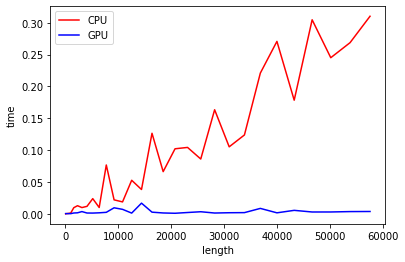

In [ ]:
import matplotlib.pyplot as plt

plt.plot([64,256,576,1024,1600,2304,3136,4096,5184,6400,7744,9216,10816,12544,14400,16384,18496,20736,23104,25600,28224,30976,33856,36864,40000,43264,46656,50176,53824,57600],
         [0.000061, 0.000568, 0.000791, 0.001440, 0.009837, 0.012945, 0.010020, 0.011942, 0.024027, 0.010126, 0.076821, 0.022127, 0.018900, 0.052845, 0.038355, 0.126592, 0.066403, 0.102240, 0.104391, 0.086186, 0.163488, 0.105334, 0.123941, 0.221025, 0.270735, 0.178481, 0.304650, 0.245143, 0.268754, 0.310198], 'r', label="CPU");

plt.plot([64,256,576,1024,1600,2304,3136,4096,5184,6400,7744,9216,10816,12544,14400,16384,18496,20736,23104,25600,28224,30976,33856,36864,40000,43264,46656,50176,53824,57600],
         [0.000581, 0.000521, 0.000523, 0.000480, 0.001507, 0.001793, 0.003722, 0.001465, 0.001380, 0.001794, 0.002558, 0.009653, 0.007240, 0.001356, 0.016958, 0.002808, 0.001547, 0.001080, 0.002267, 0.003468, 0.001458, 0.001913, 0.002087, 0.008713, 0.001772, 0.005657, 0.003078, 0.003106, 0.003716, 0.003868], 'b', label="GPU");

plt.xlabel("length")
plt.ylabel("time")
plt.legend()

# [64,256,576,1024,1600,2304,3136,4096,5184,6400,7744,9216,10816,12544,14400,16384,18496,20736,23104,25600,28224,30976,33856,36864,40000,43264,46656,50176,53824,57600] 
# [8,16,24,32,40,48,56,64,72,80,88,96,104,112,120,128,136,144,152,160,168,176,184,192,200,208,216,224,232,240]        

plt.show()